**Chapter 14 – Deep Computer Vision Using Convolutional Neural Networks**
# Глава 14 - Глубокое компьютерное зрение с использованием сверточных нейронных сетей

# Установка
Для начала, давайте импортируем несколько общих модулей, убедимся, что MatplotLib строит графики рисунков inline и подготовим функцию для сохранения рисунков. Мы также проверим, установлен ли Python 3.5 или более поздняя версия (хотя Python 2.x может работать, он устарел, поэтому мы настоятельно рекомендуем вам использовать вместо него Python 3), а также Scikit-Learn ≥0.20 и TensorFlow ≥2.0.

In [118]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
try:
    assert sklearn.__version__ >= "0.20", f'Version {sklearn.__version__} is used. Need another version'
except AssertionError as ex:
    raise
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
try:
    assert tf.__version__ >= "2.0",f'Version {tf.__version__} is used. Need another version'
except AssertionError as ex:
    raise

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# Введение

Хотя суперкомпьютер IВМ Deep Вlue победил чемпиона мира по шахма­там Гарри Каспарова еще в 1996 году, до недавнего времени компьютеры не были способны надежно выполнять на вид простые задачи, такие как обна­ружение щенка на фотографии или распознавание сказанных слов. Почему эти задачи настолько легки для нас, людей? Ответ заключается в том, что восприятие в основном происходит за пределами нашего сознания, внутри специализированных зрительных, слуховых и других сенсорных модулей в наших мозгах. К тому времени, когда сенсорная информация достигает на­шего сознания, она уже оснащена высокоуровневыми признаками; например, глядя на фотографию забавного щенка, вы не в состоянии сделать выбор не видеть щенка или не заметить, что он забавный. Вы также не можете объ­яснить, как вы распознали забавного щенка; для вас это просто очевидно. 
Таким образом, мы не можем доверять своему субъективному опыту: вос­приятие вообще не является тривиальным и для его понимания мы должны посмотреть, как работают сенсорные модули. 

Сверточные нейронные сети (Convolиtional Neиral Network - CNN) поя­
вились в результате изучения зрительной коры головного мозга и применя­лись в распознавании изображений, начиная с 1980-х годов. Благодаря росту вычислительной мощности в последние несколько лет, увеличению объема доступных обучающих данных и появлению трюков для обучения глубоких сетей, которые были представлены в главе 11, сетям CNN удалось достичь сверхчеловеческой производительности при решении ряда сложных зритель­ных задач. Они приводят в действие мощные службы поиска изображений, беспилотные автомобили, системы автоматической классификации видеоро­ликов и т.п. Кроме того, сети CNN не ограничиваются зрительным воспри­ятием: они также успешно решают другие задачи вроде распознавания речи 
(voice recognition) или обработки естественного языка (Natural Language 
Processing - NLP); однако пока что мы сосредоточимся на зрительных упот­реблениях. 

В этой главе мы рассмотрим, откуда взялись CNN, как выглядят их строительные блоки и как их реализовать с помощью TensorFlow и Keras. Затем мы обсудим некоторые из лучших архитектур CNN, а также другие визуальные задачи, включая обнаружение объектов (классификация нескольких объектов на изображении и размещение вокруг них ограничивающих рамок) и семантическую сегментацию (классификация каждого пикселя в соответствии с классом объекта, к которому он принадлежит).

# Строение зрительной коры головноrо мозrа 
Дэвид Х. Хьюбел и Торстен Визель провели серию экспериментов на кош­ках в 1958 и 1959 годах (а спустя несколько лет также на обезьянах), вы­явив важнейшие сведения о структуре зрительной коры головного мозга (в 1981 году авторы получили за свою работу Нобелевскую премию в об­ласти физиологии или медицины). В частности, они показали, что многие нейроны в зрительной коре имеют небольшое локальное рецепторное поле (local receptive field), а потому реагируют на зрительные раздражители, на­ходящиеся в ограниченной области поля зрения (на рис. 14-1 локальные ре­цепторные поля пяти нейронов представлены пунктирными окружностями). 

Рецепторные поля разных нейронов могут перекрываться и вместе они ох­ватывают все поле зрения. Вдобавок авторы продемонстрировали, что неко­торые нейроны реагируют только на изображения горизонтальных линий, в то время как другие - на линии в разных направлениях (два нейрона могут иметь одно и то же рецепторное поле, но реагировать на линии с отличаю­щимися направлениями). Они также заметили, что некоторые нейроны об­ладают большими рецепторными полями и реагируют на более сложные об­разы, являющиеся комбинациями низкоуровневых образов. Эти наблюдения привели к мысли о том, что нейроны более высокого уровня основываются на выходах соседствующих нейронов более низкого уровня (обратите внима­ние на рис. 14-1, что каждый нейрон связан только с несколькими нейронами из предыдущего уровня). Такая мощная архитектура способна обнаруживать все виды сложных образов в любой области поля зрения. 
<style>
figure.img {
  max-width: 60%;
  margin: 0 auto;
  text-align: center;
  width: content; 

}
figure.img figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
figure.img2{
  max-width: 80%;
  margin: 0 auto;
  width: content;
}

TD.leftcol {
width: 110px; /* Ширина левой колонки с рисунком */
vertical-align: top; /* Выравнивание по верхнему краю */
}
</style>

<figure class="img">
    <img 
    src="./images/book/img1.png"
    alt="">
    <figcaption>
    Рис 14-1. Биологические нейроны в зрительной коре реагируют на определенные паттерны в небольших областях поля зрения, называемых рецептивными полями; по мере того как визуальный сигнал проходит через последовательные модули мозга, нейроны реагируют на более сложные паттерны в более крупных рецептивных полях.    
    </figcaption>
</figure>

Проведенные исследования зрительной коры вдохновили на создание в 1980 году неокогнитрона (neocognitron), который постепенно развился в то, что сейчас мы называем сверточными нейронными сетями. Важной вехой стала работа 1998 года Яна Лекуна, Леона Батту, Йошуа Бенджи и Патрика Хаффнера, в которой была введена знаменитая архитектура LeNet-5, широко применяемая для распознавания рукописных чисел на чеках. Эта архитекту­ра содержит ряд строительных блоков, которые вам уже известны, в том чис­ле полносвязные слои и сигмоидальные функции активации, но она также представляет два новых строительных блока: сверточные слои ( convolutional 
layer) и объединяющие слои (pooling layer). Давайте рассмотрим их. 

<table width="100%" cellspacing="0" cellpadding="0">
   <tr> 
    <td class="leftcol">
    <figure class="img2">
      <img 
      src="./images/book/bird.png"
      alt="">
    </figure>
    </td>
    <td valign="top" style="margin-left: 100px">Почему для решения задач распознавания изображений просто не воспользоваться обыкновенной глубокой нейронной сетью с полносвязными слоями? К сожалению, хотя она хорошо работа­ет для небольших изображений (скажем, MNIST), в случае более крупных изображений ее работа нарушается из-за гигантского количества требующихся параметров. Например, изображение 100 х 100 содержит 1ОООО пикселей, и если первый слой имеет лишь 1ООО нейронов (что уже серьезно ограничивает объем ин­формации, передаваемой следующему слою), то в итоге получится 10 миллионов связей. И это только первый слой. Сети CNN реша­ют такую проблему с применением частично связных слоев.</td>
   </tr>
</table>





# Сверточный слой
Самый важный строительный блок сети CNN - это сверточный слой: нейроны в первом сверточном слое не связаны с каждым одиночным пиксе­лем во входном изображении (как было в предшествующих главах), а только с пикселями в собственных рецепторных полях (рис. 14-2). В свою очередь каждый нейрон во втором сверточном слое связан только с нейронами, на­ходящимися внутри небольшого прямоугольника в первом слое. Такая ар­хитектура позволяет сети сосредоточиться на низкоуровневых признаках в первом скрытом слое, затем скомпоновать их в признаки более высокого уровня в следующем скрытом слое и т.д. Подобная иерархическая структура распространена в реальных изображениях, что и является одной из причин, почему сети CNN настолько хорошо работают при распознавании изобра­жений.

Свертка - это математическая операция, которая плавно перемещает одну функцию по другой и измеряет интеграл их точечного умножения. Она имеет глубинные связи с преобразованием Фурье и преобразованием Лапласа и интенсивно используется в обработке сигналов. Сверточные слои на самом деле применяют взаимную корреля­цию, которая очень похожа на свертку.
<style>
figure.img {
  max-width: 60%;
  margin: 0 auto;
  text-align: center;
  width: content; 

}
figure.img figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
figure.img2{
  max-width: 80%;
  margin: 0 auto;
  width: content;
}

TD.leftcol {
width: 110px; /* Ширина левой колонки с рисунком */
vertical-align: top; /* Выравнивание по верхнему краю */
}
</style>

<figure class="img">
    <img 
    src="./images/book/img2.png"
    alt="">
    <figcaption>
    Рис 14-2. Слои сети CNN с прямоугольными локальными рецепторными полями.    
    </figcaption>
</figure>

<br>

<table width="100%" cellspacing="0" cellpadding="0">
   <tr> 
    <td class="leftcol">
    <figure class="img2">
      <img 
      src="./images/book/bird.png"
      alt="">
    </figure>
    </td>
    <td valign="top" style="margin-left: 100px">Все рассмотренные до сих пор многослойные нейронные сети имели слои, состоящие из длинной линейки нейронов, и нам приходилось разглаживать входные изображения до одного измерения, прежде чем передавать их нейронной сети. Теперь каждый слой представлен в двух измерениях, что облегчает со­поставление нейронов с соответствующими им входами.</td>
   </tr>
</table>


Нейрон, расположенный в строке $i$ и столбце $j$ заданного слоя, связыва­ется с выходами нейронов предыдущего слоя, которые находятся в строках с $i$ по $i + f_h - 1$ и столбцах с $j$ по $j + f_w - 1$, где $f_h$ и $f_w$  - высота и ширина ре­цепторного поля (рис. 14-3). Для того чтобы слой имел такую же высоту и ширину, как у предыдущего слоя, вокруг входов обычно добавляют нули, что и видно на рис. 14-3. Это называется дополнением нулями (zero padding). 

<figure class="img">
    <img 
    src="./images/book/img3.png"
    alt="">
    <figcaption>
    Рис 14-3. Связи между слоями и дополнение нулями.    
    </figcaption>
</figure>

Также можно связать крупный входной слой с гораздо меньшим слоем, растягивая рецепторные поля (рис. 14-4). Расстояние между двумя после­довательными рецепторными полями называется страйдом (stride), или большим шагом. На рис. 14-4 входной слой 5 х 7 (плюс дополнение нуля­ми) связывается со слоем 3 х 4, используя рецепторные поля 3 х 3 и страйд 2 (в данном примере страйд одинаков в двух направлениях, но он вовсе не обязан быть таким). Нейрон, расположенный в строке $i$ и столбце $j$ более вы­сокого слоя, связывается с выходами нейронов предыдущего слоя, которые находятся в строках с $i \times s_h$ по $i \times s_h + f_h - 1$ и столбцах с $j \times s_w$ по $j \times s_w + f_w - 1$, где $s_h$ и $s_w$ - вертикальный и горизонтальный страйды. 

<figure class="img">
    <img 
    src="./images/book/img4.png"
    alt="">
    <figcaption>
    Рис 14-4. Понижение размерности с применением страйда 2.    
    </figcaption>
</figure>


# Фильтры
Веса нейронов могут быть представлены как небольшие изображения с размером рецепторного поля. Например, на рис. 14-5 показаны два возмож­
ных набора весов, называемые фильтрами filter) или сверточными ядрами 
(convolution kernel). Первый фильтр представлен в виде черного квадрата с вертикальной белой линией в середине (это матрица 7 х 7, которая заполне­на нулями за исключением центрального столбца, заполненного единицами); нейроны, использующие такие веса, будут игнорировать в своем рецептор­ном поле все кроме центральной вертикальной линии (потому что все вхо­ды будут умножаться на О за исключением входов, расположенных на цент­ральной вертикальной линии). Второй фильтр имеет вид черного квадрата с горизонтальной белой линией в середине. И снова нейроны, использующие такие веса, будут игнорировать в своем рецепторном поле все кроме цент­ральной горизонтальной линии. 

Теперь если все нейроны в слое используют один и тот же фильтр с вер­тикальной линией (и тот же самый член смещения), и вы передаете сети входное изображение, приведенное на рис. 14-5 (нижнее изображение), то слой выдаст левое верхнее изображение. Обратите внимание, что верти­кальные белые линии усилились, в то время как остальное стало размытым.Аналогично правое верхнее изображение представляет собой то, что будет получено, если все нейроны применяют фильтр с горизонтальной линией;заметно, что горизонтальные белые линии усилились, а остальное стало раз­мытым. Таким образом, слой с нейронами, использующими один и тот же фильтр, выдает карту признаков (feature mар), которая выделяет области изображения, наиболее сходные с фильтром. Во время обучения сеть CNN находит самые пригодные фильтры для своей задачи и учится комбиниро­вать их в более сложные образы (скажем, крест является областью, где ак­тивны оба фильтра - с вертикальной линией и с горизонтальной линией).

<style>
figure.img {
  max-width: 60%;
  margin: 0 auto;
  text-align: center;
  width: content; 

}
figure.img figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
</style>

<figure class="img">
    <img 
    src="./images/book/img5.png"
    alt="">
    <figcaption>
    Рис 14-5. Применение двух разных фильтров для получения карт признаков.    
    </figcaption>
</figure>


# Наложение множества карт признаков
До сих пор ради простоты мы представляли каждый сверточный слой как тонкий двумерный слой, но в реальности он состоит из нескольких карт признаков равных размеров, поэтому более точно представляется в трех из­мерениях (рис. 14-6). Внутри одной карты признаков все нейроны разделяют те же самые параметры (веса и член смещения), но разные карты признаков могут иметь отличающиеся параметры. Рецепторное поле нейрона такое же, как описано ранее, но оно распространяется на все карты признаков пред­шествующих слоев. Короче говоря, сверточный слой одновременно применя­ет множество фильтров к своим входам, становясь способным обнаруживать множество признаков повсюду в своих входах. 

<style>
figure.img {
  max-width: 60%;
  margin: 0 auto;
  text-align: center;
  width: content; 

}
figure.img figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
figure.img2{
  max-width: 80%;
  margin: 0 auto;
  width: content;
}

TD.leftcol {
width: 110px; /* Ширина левой колонки с рисунком */
vertical-align: top; /* Выравнивание по верхнему краю */
}
</style>

<table width="100%" cellspacing="0" cellpadding="0">
   <tr> 
    <td class="leftcol">
    <figure class="img2">
      <img 
      src="./images/book/bird.png"
      alt="">
    </figure>
    </td>
    <td valign="top" style="margin-left: 100px">Тот факт, что все нейроны в карте признаков разделяют те же самые параметры, значительно сокращает количество пара­метров в модели, но более важно то, что после обучения сети CNN распознаванию образа в одном положении, она способна распознавать его в любом другом положении. Напротив, после того, как обыкновенная сеть DNN обучена распознаванию об­раза в одном положении, она может распознавать его только в этом конкретном положении.</td>
   </tr>
</table>


Кроме того, входные изображения также состоят из множества подсло­ев: по одному на цветовой канал. Их обычно три: красный, зеленый и си­ний (red, green, Ыuе - RGB). Полутоновые изображения имеют только один канал, но некоторые изображения могут иметь гораздо больше каналов -например, изображения со спутников, фиксирующие свет дополнительных частот (такой как инфракрасный). 
<figure class="img">
    <img 
    src="./images/book/img6.png"
    alt="">
    <figcaption>
    Рис 14-6. Сверточные слои с множеством карт признаков и изображения с тремя каналами.    
    </figcaption>
</figure>

В частности, нейрон, расположенный в строке $i$ и столбце $j$ карты при­знаков $k$ в заданном сверточном слое $l$, связывается с выходами нейронов в предыдущем слое $l - 1$, который находится в строках с $i \times s_h$ по $i \times s_h + f_h - 1$ и столбцах с $j \times s_w$ по $j \times s_w + f_w - 1$ через все карты признаков (в слое $l - 1$).Обратите внимание, что все нейроны, расположенные в той же самой строке $i$ и столбце $j$, но в разных картах признаков, связываются с выходами точно тех же нейронов в предыдущем слое. 

В уравнении 14-1 приведенные объяснения подытоживаются в одно боль­шое математическое уравнение: оно показывает, как вычислять выход задан­ного нейрона в сверточном слое. Из-за обилия разных индексов уравнение выглядит несколько неуклюжим, но все, что оно делает - вычисляет взве­шенную сумму всех входов плюс член смещения. 

Уравнение 14-1. Вычисление выхода нейрона в сверточном слое \
$z_{i,j,k} = b_k + \sum \limits _{u=0} ^{f_h-1} \sum \limits _{v=0} ^{f_w-1} \sum \limits _{k^{'}=0} ^{f_{n^{'}}-1} x_{i^{'},j^{'},k^{'}} \cdot w_{u,v,k^{'},k} \quad с \quad \begin{cases} i^{'} = i \times s_h + u \\ j^{'} = j \times s_w + v \end{cases} \hspace{180pt} \text{(14-1)}$

- $z_{i,j,k}$ - выход нейрона, расположенного в строке $i$ и столбце $j$ в карте признаков $k$ сверточного слоя (слоя $l$). 
- Как объяснялось ранее, $s_h$ и $s_w$ - вертикальный и горизонтальный страйды, $f_h$ и $f_w$ - высота и ширина рецепторного поля, а $f_{п^{'}}$ - коли­чество карт признаков в предыдущем слое (слое $l - 1$).
- $x_{i^{'},j^{'},k^{'}}$ - выход нейрона, расположенного в слое $l - 1$, строка $i^{'}$, столбец $j^{'}$, карта признаков $k^{'}$ (или канал $k^{'}$, если предыдущий слой является вход­ным).
- $b_k$ - член смещения для карты признаков $k$ (в слое $l$). Вы можете ду­мать об этом как о ручке управления, которая регулирует общую яр­кость карты признаков $k$.
- $w_{u,v,k^{'},k}$ - вес связи между любым нейроном в карте признаков $k$ слоя $l$ и его входом, расположенным в строке $u$, столбце $v$ (относительно ре­цепторного поля нейрона) и карте признаков $k^{'}$. 


# Реализация с помощью TensorFlow

В TensorFlow каждое входное изображение обычно представляется как трехмерный тензор в форме [высота, ширина, каналы]. Мини-пакет пред­ставляется как четырехмерный тензор в форме [размер мини-пакета, высота, ширина, каналы]. Веса сверточного слоя представляются как четырехмерный тензор в форме [$f_h, f_w, f_{n^{'}}, f_n$]. Члены смещения сверточного слоя представля­ются просто как одномерный тензор в форме [$f_n$]. 

Давайте рассмотрим простой пример. Приведенный ниже код загружает два примера изображений, используя функцию `load_sample_images()` из Scikit-Learn (которая загружает два цветных изображения, одно с храмом и одно с цветком). Затем код создает два фильтра 7 х 7 и применяет их к обоим изображениям с использованием сверточного слоя и, наконец, код показывает результат.

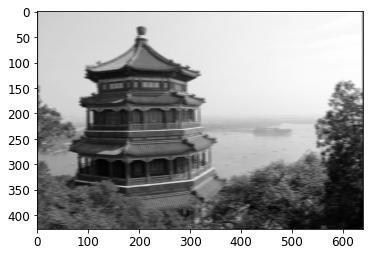

In [6]:
from sklearn.datasets import load_sample_image

# Загрузка изображений
china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Создание двух фильтров
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # Вертикальная линия
filters[3, :, :, 1] = 1  # Горизонтальная линия

# Сверточный слой
# strides = 1 or strides = [1,1,1,1]
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME") 
plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.show()


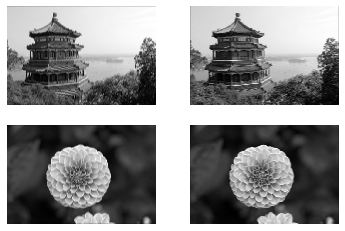

In [3]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [4]:
def crop(images):
    return images[150:220, 130:250]

Saving figure china_original


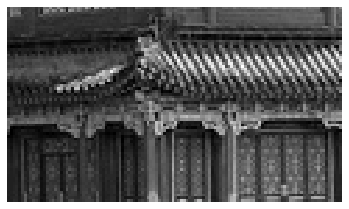

Saving figure china_vertical


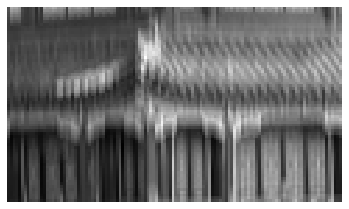

Saving figure china_horizontal


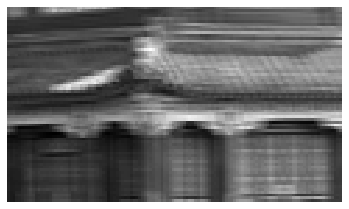

In [5]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

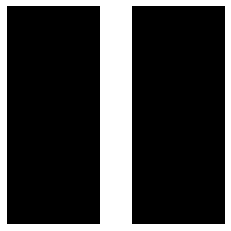

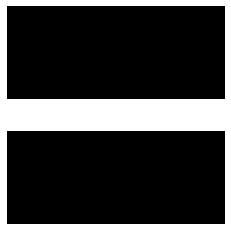

In [13]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

Давайте пройдемся по этому коду:
- Интенсивность пикселя для каждого цветового канала представлена в виде байта от 0 до 255, поэтому мы масштабируем эти функции, просто разделив их на 255, чтобы получить значения с плавающей запятой в диапазоне от 0 до 1.
- Затем мы создаем два фильтра 7 × 7 (один с вертикальной белой линией посередине, а другой с горизонтальной белой линией посередине).
- Мы применяем два фильтра к обоим изображениям с помощью функции `tf.nn.conv2d()`, которая является частью низкоуровневого API глубокого обучения TensorFlow. В этом примере мы используем нулевой отступ (`padding="SAME"`) и шаг 1 (`stride=1`).
- Наконец, мы вычерчиваем одну из карт признаков первого изображения.

Строка `tf.nn.conv2d()` заслужи­вает некоторых пояснений:
- `images` - входной мини-пакет (четырехмерный тензор, как объяснялось ранее).
- `filters` - набор фильтров, подлежащих применению (также четы­рехмерный тензор, как объяснялось ранее). 
- `strides` - шаг рецепторного поля ($s_h$ и $s_w$) равный 1, но это может быть четырехэлементный одномерный массив, где два централь­ных элемента представляют собой вертикальный и горизонтальный страйды ($s_h$ и $s_w$). Первый и последний элементы в текущий момент должны быть равны 1. В один прекрасный день они могут использо­ваться для указания страйда пакета (чтобы пропускать некоторые об­разцы) и страйда канала (чтобы пропускать некоторые карты призна­ков или каналы предыдущего слоя).
- `padding` - должен быть установлен либо в "VALID", либо в "SАМЕ":
   - Если `padding` установлен в "SАМЕ", то сверточный слой при необ­ходимости использует дополнение нулями. В таком случае количес­тво выходных нейронов равно числу входных нейронов, деленному на страйд, с округлением в большую сторону. Например, если входной размер равен 13, а страйд равен 5 (рис. 14-7), то выходной размер равен 3 (т.е. 13/5 = 2,6, округленное до 3).  Затем вокруг входов как можно более равномерно добавляются нули. Когда страйд равен 1, выходной слой будет иметь те же пространственные размеры (ширину и высоту), что и его входной слой, отсюда и название такой-же(same). 
   - Если `padding` установлен в "VALID", то сверточный слой не задейс­твует дополнение нулями и может игнорировать некоторые строки и столбцы внизу и справа входного изображения в зависимости от страйда, как демонстрируется на рис. 14-7 (для простоты здесь пока­зано только горизонтальное измерение, но, само собой разумеется, та же самая логика применима и к вертикальному измерению). Это означает, что рецептивное поле каждого нейрона находится строго в допустимых позициях внутри входных данных (оно не выходит за границы), отсюда и название допустимое(valid).


<style>
figure.img {
  max-width: 60%;
  margin: 0 auto;
  text-align: center;
  width: content; 

}
figure.img figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
</style>

<figure class="img">
    <img 
    src="./images/book/img7.png"
    alt="">
    <figcaption>
    Рис 14-7. Варианты дополнения - ширина входа: 13, ширина фильтра: 6, страйд: 5.    
    </figcaption>
</figure>

В этом примере мы вручную определили фильтры, но в реальной CNN вы обычно определяете фильтры как обучаемые переменные, чтобы нейронная сеть могла узнать, какие фильтры работают лучше всего. Вместо создания переменных вручную используйте слой `keras.layers.Conv2D`.

`conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu")`

Этот код создает слой Conv2D с 32 фильтрами, каждый 3 × 3, используя шаг 1 (как по горизонтали, так и по вертикали) и «SAME» дополнение, а также применяя функцию активации ReLU к своим выходам. Как видите, сверточные слои имеют довольно много гиперпараметров: вы должны выбрать количество фильтров, их высоту и ширину, шаг и тип заполнения. Как всегда, вы можете использовать перекрестную проверку, чтобы найти правильные значения гиперпараметров, но это требует очень много времени. Мы обсудим распространенные архитектуры CNN позже, чтобы дать вам некоторое представление о том, какие значения гиперпараметров лучше всего работают на практике.

Давайте создадим 2D сверточный слой, используя `keras.layers.Conv2D()`:

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1,
 padding="SAME", activation="relu", input_shape=outputs.shape)

Назовем этот слой, передав ему два тестовых изображения:

In [26]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

Выход представляет собой четырехмерный тензор. Размеры: размер мини-пакета, высота, ширина, каналы. Первое измерение (размер пакета) равно 2, так как есть 2 входных изображения. Следующие два измерения — это высота и ширина выходных карт объектов: поскольку `padding="SAME"` и `strides=1`, выходные карты объектов имеют ту же высоту и ширину, что и входные изображения (в данном случае 427 × 640). Наконец, этот сверточный слой имеет 2 фильтра, поэтому последнее измерение равно 2: для каждого входного изображения есть 2 выходные карты призакнов.

Поскольку фильтры инициализируются случайным образом, они изначально будут обнаруживать случайные шаблоны. Давайте посмотрим на две выходные карты признаков для каждого изображения:

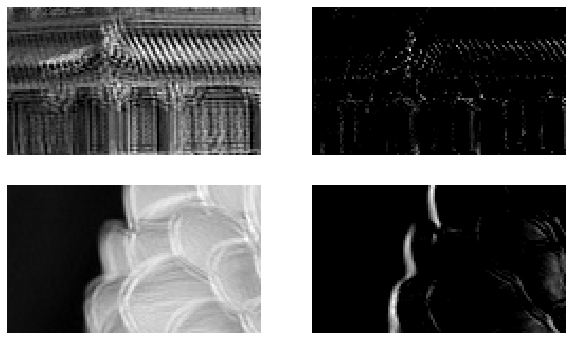

In [27]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

Хотя фильтры были инициализированы случайным образом, второй фильтр действует как детектор границ. Случайно инициализированные фильтры часто действуют таким образом, что весьма удачно, поскольку обнаружение краев весьма полезно при обработке изображений. Если мы хотим, мы можем установить фильтры так, как мы вручную определили ранее, и установить смещения (biases) на нули (в реальной жизни нам почти никогда не потребуется устанавливать фильтры или смещения вручную, поскольку сверточный слой просто выучит соответствующие фильтры и смещения во время обучения):

In [28]:
conv.set_weights([filters, np.zeros(2)])

Теперь давайте снова вызовем этот слой для тех же двух изображений и проверим, что выходные карты объектов выделяют вертикальные и горизонтальные линии соответственно (как и ранее):

In [29]:
conv_outputs = conv(images)
conv_outputs.shape 

TensorShape([2, 427, 640, 2])

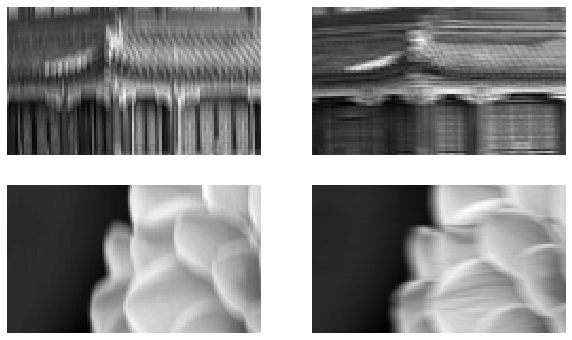

In [30]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

Сравним дополнения `valid` и `same`:

In [43]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images


Использование дополнение `"SAME"` эквивалентно дополнение вручную с помощью `manual_same_padding()`, а затем использованию дополнения `"VALID"` (как ни странно, заполнение `"VALID"` означает полное отсутствие дополнения):

In [44]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Need to call build() so conv_same's weights get created
conv_same.build(tf.TensorShape(images.shape))

# Copy the weights from conv_valid to conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())


# Требования к памяти

Еще одна проблема сетей CNN заключается в том, что сверточные слои требуют огромного объема оперативной памяти, особенно во время обуче­ния, поскольку при проходе назад обратного распространения нужны все промежуточные значения, вычисленные в течение прохода вперед. 

Например, возьмем сверточный слой с фильтрами 5 х 5, выдающий 200 карт признаков размером 150 х 100, со страйдом 1 и дополнением "SАМЕ". Если на вход передается RGВ-изображение 150 х 100 (три канала), тогда количество параметров составляет (5 х 5 х 3 + 1) х 200 = 15200 ( + 1 соответ­ствует членам смещения (bias)), что достаточно немного в сравнении с полносвяз­ным слоем (Полносвязный слой с 150 х 100 нейронами, каждый из которых связан со всеми 150 х 100 х 3 входами, имел бы $150^2$ х $100^2$ х 3 = 675 миллионов параметров). Тем не менее, каждая из 200 карт признаков содержит 150 х 100 нейронов, а каждый нейрон нуждается в вычислении взвешенной суммы своих 5 х 5 х 3 = 75 входов: всего 225 миллионов операций умножения с пла­вающей точкой. Не настолько плохо, как у полносвязного слоя, но все-таки достаточно интенсивно в вычислительном отношении. Кроме того, если кар­ты признаков представлены с применением 32-битовых значений с плаваю­щей точкой, то выход сверточного слоя будет занимать 200 х 150 х 100 х 32 = 96 миллионов битов (около 11.4 Мбайт) оперативной памяти. И это лишь для одного образца! Если обучающий пакет содержит 100 образцов, тогда дан­ный слой будет использовать свыше 1 Гбайт оперативной памяти!

Во время выведения (т.е. выработки прогноза для нового образца) опера­тивная память, занятая одним слоем, может быть освобождена, как только вычислен следующий слой, поэтому оперативной памяти необходимо иметь столько, сколько требуется для двух последовательных слоев. Но во время обучения все, что вычисляется в течение прохода вперед, должно быть со­хранено для прохода назад, а потому оперативной памяти нужно (по край­ней мере) столько, сколько ее требуется для всех слоев. 


<style>

figure.img2{
  max-width: 80%;
  margin: 0 auto;
  width: content;
}

TD.leftcol {
width: 110px; /* Ширина левой колонки с рисунком */
vertical-align: top; /* Выравнивание по верхнему краю */
}
</style>

<table width="100%" cellspacing="0" cellpadding="0">
   <tr> 
    <td class="leftcol">
    <figure class="img2">
      <img 
      src="./images/book/monk.png"
      alt="">
    </figure>
    </td>
    <td valign="top" style="margin-left: 100px"> Если обучение терпит неудачу из-за ошибки, вызванной нехват­кой памяти, тогда вы можете попробовать сократить размер мини-пакета. В качестве альтернативы вы можете попытаться понизить размерность с применением страйда или удалить не­сколько слоев. Либо вы можете использовать 16-битовые значения с плавающей точкой вместо 32-битовых. Или же можете распределить сеть CNN между множеством устройств. </tr>
</table>

А теперь давайте посмотрим на второй общий строительный блок в сетях 
CNN: объединяющий слой. 




# Объединяющий слой

Разобравшись в том, как работают сверточные слои, понять назначение объединяющих слоев (называемых также субдискретизирующими слоями или слоями подвыборки - примеч. пер.) довольно легко. Их цель заключает­ся в том, чтобы проредить (т.е. сжать) входное изображение для сокращения вычислительной нагрузки, расхода памяти и количества параметров (тем са­мым ограничивая риск переобучения). 

Как и в сверточных слоях, каждый нейрон в объединяющем слое связан с выходами ограниченного числа нейронов из предыдущего слоя, которые рас­положены внутри небольшого прямоугольного рецепторного поля. Вы должны определить его размер, страйд и тип дополнения, точно как раньше. Однако объединяющий нейрон не имеет весов; он лишь агрегирует входы с примене­нием функции агрегирования, такой как максимум или среднее. На рис. 14-8 показан слой объединения по максимуму (max pooling layer), который является самым распространенным типом объединяющего слоя. В данном примере мы используем объединяющее ядро (pooling kernel) 2 х 2, страйд 2, без дополнения. Обратите внимание, что на следующий слой попадает только максимальное входное значение в каждом ядре. Остальные входы отбрасываются. Например, в нижнем левом рецептивном поле на рис. 14-8 входными значениями являются 1, 5, 3, 2, поэтому на следующий уровень передается только максимальное значение 5. Из-за шага, равного 2, выходное изображение имеет половину высоты и половину ширины входного изображения (округлено в меньшую сторону, поскольку мы не используем отступы).

<style>
figure.img {
  max-width: 60%;
  margin: 0 auto;
  text-align: center;
  width: content; 

}
figure.img figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
figure.img2{
  max-width: 80%;
  margin: 0 auto;
  width: content;
}

TD.leftcol {
width: 110px; /* Ширина левой колонки с рисунком */
vertical-align: top; /* Выравнивание по верхнему краю */
}
</style>

<figure class="img">
    <img 
    src="./images/book/img8.png"
    alt="">
    <figcaption>
    Рис 14-8. Слой объединения по максимуму (объединяющее ядро 2 х 2, страйд 2, без дополнения).    
    </figcaption>
</figure>

<br>

<table width="100%" cellspacing="0" cellpadding="0">
   <tr> 
    <td class="leftcol">
    <figure class="img2">
      <img 
      src="./images/book/bird.png"
      alt="">
    </figure>
    </td>
    <td valign="top" style="margin-left: 100px"> Слой объединения обычно работает с каждым входным каналом независимо, поэтому глубина вывода совпадает с глубиной ввода. </tr>
</table>

Помимо сокращения объема вычислений, использования памяти и количества параметров, уровень максимального объединения также вводит некоторый уровень инвариантности к малым трансляциям, как показано на рис. 14-9. Здесь мы предполагаем, что яркие пиксели имеют более низкое значение, чем темные пиксели, и мы рассматриваем три изображения (A, B, C), проходящие через максимальный объединяющий слой с ядром 2 × 2 и шагом 2. Изображения B и C такие же, как изображение A, но смещены на один и два пикселя вправо. 

Как видите, выходные данные слоя максимального объединения для изображений A и B идентичны. Это и означает трансляционная инвариантность. Для изображения C результат другой: он сдвинут на один пиксель вправо (но по-прежнему сохраняется 75% инвариантность). Вставляя максимальный объединяющий слой каждые несколько слоев в CNN, можно получить некоторый уровень трансляционной инвариантности в большем масштабе. Более того, максимальное объединение предлагает небольшую инвариантность к вращению и небольшую инвариантность к масштабу. Такая инвариантность (даже если она ограничена) может быть полезна в случаях, когда предсказание не должно зависеть от этих деталей, например, в задачах классификации.

<figure class="img">
    <img 
    src="./images/book/img9.png"
    alt="">
    <figcaption>
    Рис 14-9. Инвариантность к малым трансляциям.    
    </figcaption>
</figure>

Очевидно, это крайне деструктивный вид слоя: даже с крошечным ядром 2 х 2 и страйдом 2 выход будет в два раза меньше в обоих направлениях (так что его площадь окажется в четыре раза меньше) из-за простого отбрасыва­ния 75% входных значений. А в некоторых приложениях инвариантность нежелательна. Возьмем семантическую сегментацию (задача классификации каждого пикселя изображения в соответствии с объектом, которому этот пиксель принадлежит, который мы рассмотрим позже в этой главе): очевидно, если входное изображение сдвинуто на один пиксель вправо, выходное изображение также должно быть сдвинуто на один пиксель вправо. Целью в этом случае является эквивариантность, а не инвариантность: небольшое изменение на входе должно привести к соответствующему небольшому изменению на выходе.

# Реализация TensorFlow
Реализовать слой объединения по максимуму в TensorFlow довольно лег­ко. Следующий код создает слой объединения по максимуму, используя ядро 2 х 2, страйд 2, без дополнения, и затем применяет его ко всем изображениям в наборе данных:

In [45]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [46]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

Saving figure china_max_pooling


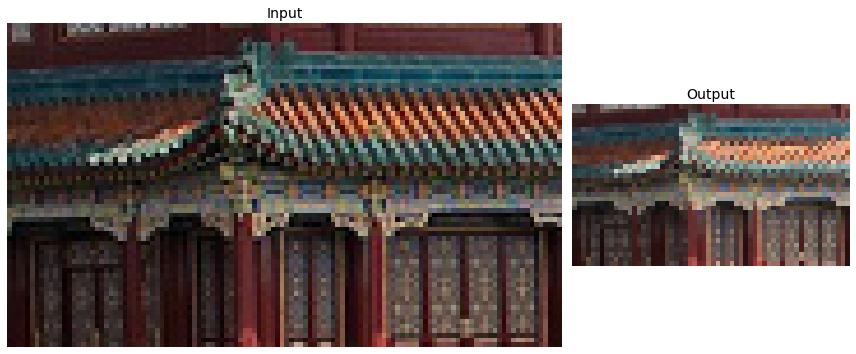

In [47]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

Чтобы создать слой обьединения по среднему, просто используйте AvgPool2D вместо MaxPool2D. Как и следовало ожидать, он работает точно так же, как слой обьединения по максимуму, за исключением того, что он вычисляет среднее, а не максимальное значение. Слой обьединения по среднему раньше были очень популярны, но сейчас люди в основном используют слой обьединения по максимуму, поскольку они обычно работают лучше. Это может показаться удивительным, поскольку при вычислении среднего обычно теряется меньше информации, чем при вычислении максимального значения. Но, с другой стороны, максимальное объединение сохраняет только самые сильные признаки, избавляясь от всех бессмысленных, поэтому следующие слои получают более чистый сигнал для работы. Кроме того, обьединение по максимуму обеспечивает более высокую инвариантность к переводу, чем обьединение по среднему, и требует немного меньше вычислений.

Объединение по среднему

In [50]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [51]:
output_avg = avg_pool(cropped_images)

Saving figure china_avg_pooling


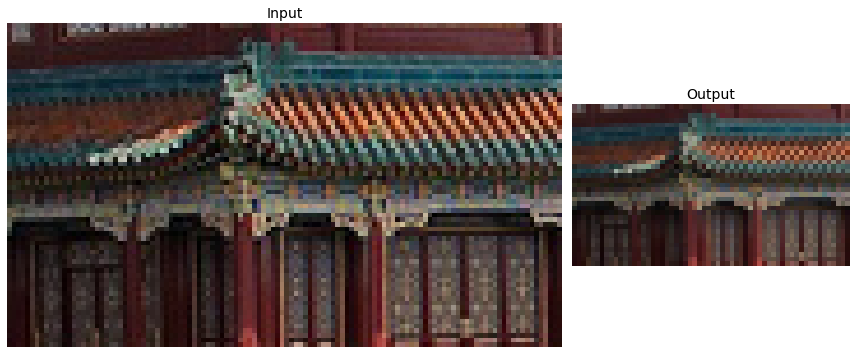

In [55]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_avg_pooling")
plt.show()


Обратите внимание, что объединение максимального и среднего значений может выполняться по измерению глубины, а не по пространственному измерению, хотя это не так распространено. Это может позволить CNN научиться быть инвариантной к различным функциям.Например, он может обучить несколько фильтров, каждый из которых будет обнаруживать разное вращение одного и того же шаблона (например, рукописные цифры; см. рис. 14-10), а слой максимального объединения по глубине гарантирует, что выходные данные будут одинаковыми независимо от поворота. Точно так же CNN может научиться быть инвариантной ко всему остальному: толщине, яркости, перекосу, цвету и так далее.
<style>
figure.img {
  max-width: 60%;
  margin: 0 auto;
  text-align: center;
  width: content; 

}
figure.img figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
</style>

<figure class="img">
    <img 
    src="./images/book/img10.png"
    alt="">
    <figcaption>
    Рис 14-10. Глубинное максимальное объединение может помочь CNN изучить любую инвариантность.    
    </figcaption>
</figure>


Keras не включает слой объединение по максимуму по глубине, но низкоуровневый API глубокого обучения TensorFlow включает: просто используйте функцию `tf.nn.max_pool()` и укажите размер ядра и шаги в виде кортежей (т. е. кортежей размера 4). Первые три значения каждого из них должны быть равны 1: это означает, что шаг по размеру пакета и размер ядра (высота и ширина) должны быть равны 1. Последнее значение должно быть любым размером ядра и шагом, который вы хотите по измерению глубины, например - 3. (это должен быть делитель входной глубины; он не будет работать, если предыдущий слой выводит 20 карт объектов, так как 20 не кратно 3):

Глубинное объединение каналов по максимуму каждого минипакета

In [95]:
# собственный слой Keras:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

Размер изображения не имзенился. Объедение было по максимальным значениям всех каналов,  каждого изображения
(2, 70, 120, 1)
Saving figure china_depthwise_max__pooling


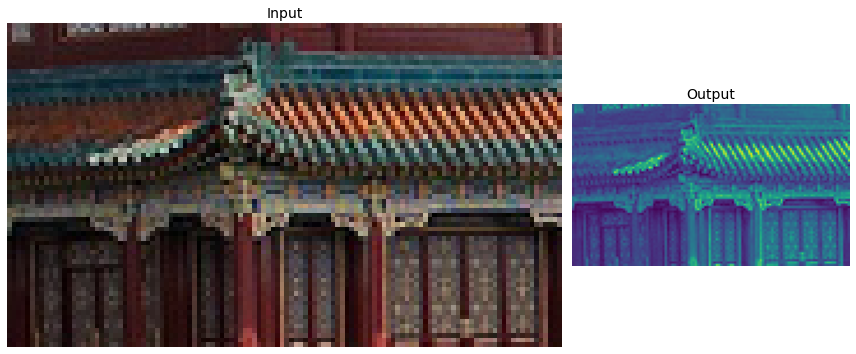

In [115]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    try:
        depth_output = depth_pool(cropped_images)
    except Exception:
        print('Размер шага глубины не кратен колличеству каналов изображения')
        raise
print('Размер изображения не имзенился.\
 Объедение было по максимальным значениям всех каналов, \
 каждого изображения')
print(depth_output.shape)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(depth_output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_depthwise_max__pooling")
plt.show()

Если вы хотите включить это как слой в свои модели Keras, оберните его слоем Lambda

In [102]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

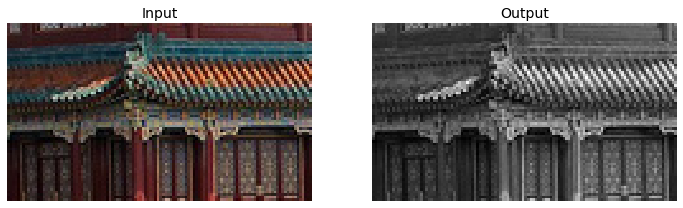

In [106]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

Последний тип слоя объединения, который вы часто будете видеть в современных архитектурах, — это глобальный слой обьеденения по среднему. Он работает совсем по-другому: все, что он делает, — это вычисляет среднее значение каждой карты признаков целиком (это похоже на слой объединения по среднему, использующий ядро объединения с теми же пространственными размерами, что и входные данные). Это означает, что он просто выводит одно число для каждой карты признаков и для каждого экземпляра. Хотя это, конечно, чрезвычайно разрушительно (большая часть информации в карте признаков теряется), она может быть полезна в качестве выходного слоя, как мы увидим позже в этой главе. Чтобы создать такой слой, просто используйте класс `keras.layers.GlobalAvgPool2D`:

In [116]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool_out = global_avg_pool(cropped_images)
print(f'Начальной тензор: {cropped_images.shape}')
print(f'Тензор полсе глобального объединения по среднему: {global_avg_pool_out.shape}')

Начальной тензор: (2, 70, 120, 3)
Тензор полсе глобального объединения по среднему: (2, 3)


Это эквивалентно этому простому лямбда-слою, который вычисляет среднее значение по пространственным измерениям (высоте и ширине):

In [117]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
global_avg_pool_out2=output_global_avg2(cropped_images)
print(f'Начальной тензор: {cropped_images.shape}')
print(f'Тензор полсе глобального объединения по среднему: {global_avg_pool_out2.shape}')

Начальной тензор: (2, 70, 120, 3)
Тензор полсе глобального объединения по среднему: (2, 3)


Теперь вы знаете все строительные блоки для создания сверточных нейронных сетей. Давайте посмотрим, как их собрать.

# Архитектуры сверточных нейронных сетей

Типовая архитектура сети CNN укладывает стопкой несколько сверточ­ных слоев (за каждым из которых следует слой ReLU), объединяющий слой, еще несколько сверточных слоев (плюс слои ReLU), снова объединяющий слой и т.д. По мере прохождения через сеть изображение становится все меньше и меньше, но обычно также глубже и глубже (т .е. с большим чис­лом карт признаков) благодаря сверточным слоям (рис. 14-11). На верхушку стопки добавляется обыкновенная нейронная сеть прямого распростране­ния, состоящая из нескольких полносвязных слоев (плюс слоев ReLU), и фи­нальный слой выдает прогноз (например, многопеременный слой, который выдает оценочные вероятности классов).

<style>
figure.img {
  max-width: 60%;
  margin: 0 auto;
  text-align: center;
  width: content; 

}
figure.img figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
figure.img2{
  max-width: 80%;
  margin: 0 auto;
  width: content;
}

TD.leftcol {
width: 110px; /* Ширина левой колонки с рисунком */
vertical-align: top; /* Выравнивание по верхнему краю */
}
</style>

<figure class="img">
    <img 
    src="./images/book/img11.png"
    alt="">
    <figcaption>
    Рис 14-11. Типовая архитектура сети CNN.    
    </figcaption>
</figure>

<br>

<table width="100%" cellspacing="0" cellpadding="0">
   <tr> 
    <td class="leftcol">
    <figure class="img2">
      <img 
      src="./images/book/monk.png"
      alt="">
    </figure>
    </td>
    <td valign="top" style="margin-left: 100px"> Распространенной ошибкой является использование слишком больших ядер свертки. Например, вместо того, чтобы использовать сверточный слой с ядром 5 × 5, сложите два слоя с ядрами 3 × 3: это будет использовать меньше параметров и потребует меньше вычислений, и обычно будет работать лучше. Единственным исключением является первый сверточный слой: обычно он может иметь большое ядро (например, 5 × 5), обычно с шагом 2 или более: это уменьшит пространственный размер изображения без потери слишком большого количества информации, а поскольку входное изображение в целом имеет только три канала, это не будет слишком дорого. </tr>
</table>

Вот как вы можете реализовать простую CNN для работы с набором данных Fashion MNIST (представленным в главе 10):

In [118]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [119]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [120]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid)) # обучение
score = model.evaluate(X_test, y_test) # оценивание
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new) # предсказывание

Epoch 1/10
1719/1719 [==============================] - 348s 201ms/step - loss: 0.7119 - accuracy: 0.7535 - val_loss: 0.3818 - val_accuracy: 0.8668
Epoch 2/10
1719/1719 [==============================] - 357s 207ms/step - loss: 0.4217 - accuracy: 0.8589 - val_loss: 0.3248 - val_accuracy: 0.8778
Epoch 3/10
1719/1719 [==============================] - 358s 208ms/step - loss: 0.3679 - accuracy: 0.8761 - val_loss: 0.3150 - val_accuracy: 0.8854
Epoch 4/10
1719/1719 [==============================] - 368s 214ms/step - loss: 0.3318 - accuracy: 0.8883 - val_loss: 0.2827 - val_accuracy: 0.8988
Epoch 5/10
1719/1719 [==============================] - 365s 212ms/step - loss: 0.3087 - accuracy: 0.8967 - val_loss: 0.2899 - val_accuracy: 0.8982
Epoch 6/10
1719/1719 [==============================] - 381s 221ms/step - loss: 0.2937 - accuracy: 0.9001 - val_loss: 0.2919 - val_accuracy: 0.8976
Epoch 7/10
1719/1719 [==============================] - 388s 226ms/step - loss: 0.2812 - accuracy: 0.9051 - val_

Пройдемся по этой модели:
- В первом слое используются 64 довольно больших фильтра (7 × 7), но без шага, потому что входные изображения не очень большие. Он также устанавливает input_shape=[28, 28, 1], поскольку изображения имеют размер 28 × 28 пикселей с одним цветовым каналом (т. е. в оттенках серого).
- Далее у нас есть слой объединения по максимуму, который использует размер пула, равный 2, поэтому он делит каждое пространственное измерение на коэффициент 2.
- Затем мы повторяем одну и ту же структуру дважды: два сверточных слоя, за которыми следует слой максимального объединения. Для больших изображений мы могли бы повторить эту структуру еще несколько раз (количество повторений — это гиперпараметр, который вы можете настроить).
- Обратите внимание, что количество фильтров растет по мере того, как мы поднимаемся по CNN к выходному слою (сначала 64, затем 128, затем 256): его рост имеет смысл, поскольку количество низкоуровневых признаков часто довольно мало. (например, маленькие круги, горизонтальные линии), но есть много разных способов их объединения в элементы более высокого уровня. Общепринятой практикой является удвоение количества фильтров после каждого объединяющего слоя: поскольку объединяющий слой делит каждое пространственное измерение в 2 раза, мы можем позволить себе удвоить количество карт объектов в следующем слое, не опасаясь взрыва числа параметров, использования памяти или вычислительной нагрузки.
- Далее идет полносвязная сеть, состоящая из двух скрытых плотных слоев и плотного выходного слоя. Обратите внимание, что мы должны сгладить его входные данные, поскольку плотная сеть ожидает одномерный массив функций для каждого экземпляра. Мы также добавляем два слоя отсева с коэффициентом отсева 50% каждый, чтобы уменьшить переоснащение.

Эта CNN достигает точности более 92% на тестовом наборе. Это не самое современное решение, но оно довольно хорошее и явно намного лучше, чем то, что мы достигли с плотными сетями в главе 10.

На протяжении многих лет были разработаны варианты этой фундамен­тальной архитектуры, что привело к удивительным успехам в данной облас­ти. Эффективной мерой развития является частота ошибок в состязаниях наподобие задачи ILSVRC ImageNet. В рамках данного состязания частота ошибок топ-5 для классификации изображений упала с более чем 26% до менее 3% всего лишь за шесть лет. Частота оши­бок топ-5 представляет собой количество испытательных изображений, для которых лучшие 5 прогнозов не включают корректный ответ. Изображения крупные (высотой 256 пикселей), есть 1 ООО классов и некоторые из них дейс­твительно едва различимы (попробуйте найти отличия между 120 породами собак). Просмотр эволюции победивших записей - хороший способ понять, как работают сети CNN. 

Сначала мы рассмотрим классическую архитектуру LeNet-5 (1998 года), а затем три победивших решения задачи ILSVRC: AlexNet (2012 года), GoogLeNet (2014 года) и ResNet (2015 года). 

# LeNet-5

Архитектура LeNet-5 является, возможно, самой широко известной ар­хитектурой сетей CNN. Как упоминалось ранее, она была создана Яном Лекуном в 1998 году и масштабно применялась для распознавания рукопис­ных цифр (MNIST). Она состоит из слоев, приведенных в табл. 14-1.

Табnица 14-1. Архитектура LeNet-5

| Слой | Тип | Карты | Размер | Размер ядра | Страйд | Активация |
| --- | --- | --- | --- | --- | --- | --- |
| Выходной | Полносвязный | - | 10 | - | - | RBF |
| F6 | Полносвязный | - | 84 | - | - | tanh |
| C5 | Сверточный | 120 | 1 х 1 | 5 х 5 | 1 | tanh |
| S4 | Объединение по среднему | 16 | 5 х 5 | 2 х 2 | 2 | tanh |
| C3 | Сверточный | 16 | 10 х 10 | 5 х 5 | 1 | tanh |
| S2 | Объединение по среднему | 6 | 14 х 14 | 2 х 2 | 2 | tanh |
| C1 | Сверточный | 6 | 28 х 28 | 5 х 5 | 1 | tanh |
| Входной | Входной | 1 | 32 х 32 | - | - | - |


Ниже отмечено несколько добавочных деталей:
- Изображения MNIST имеют 28 х 28 пикселей, но перед передачей в сеть они дополняются нулями до 32 х 32 пикселей и нормализуются. В ос­тавшейся части сети никакое дополнение не используется, а потому по мере прохождения через сеть размер продолжает уменьшаться. 
- Слои объединения по среднему чуть сложнее, чем обычно: каждый ней­рон вычисляет среднее своих входов, умножает результат на обучаемый коэффициент (один на карту) и добавляет обучаемый член смещения (тоже один на карту), после чего применяет функцию активации.
- Большинство нейронов в картах С3 связываются с нейронами лишь из трех или четырех карт S2 (вместо всех шести карт S2).
- Выходной слой несколько специфичен: вместо вычисления скалярного произведения входов и вектора весов каждый нейрон выдает возведен­ное в квадрат евклидово расстояние между своим вектором входов и своим вектором весов. Каждый выход измеряет, в какой степени изоб­ражение принадлежит отдельному классу цифр. Теперь отдается пред­почтение функции издержек на основе перекрестной энтропии, т.к. она намного больше штрафует неправильные прогнозы, порождая крупные градиенты и в итоге ускоряя схождение. 

На веб-сайте Яна Лекуна (http://yann.lecun.com/) в разделе "LENET" предлагаются замечательные демонстрации классификации цифр LeNet-5. 

# AlexNet 

В 2012 году архитектура сетей CNN под названием AlexNet с большим от­рывом победила в решении задачи ImageNet ILSVRC: она достигла 17%-ной частоты ошибок топ-5, тогда как второй результат давал только 26%! Архи­тектура AlexNet была разработана Алексом Крижевским (отсюда ее назва­ние), Ильей Сатскевером и Джеффри Хинтоном. Она довольно похожа на LeNet-5, но гораздо крупнее и глубже, к тому же, в ней сверточные слои впервые укладывались непосредственно друг на друга вместо помещения объединяющего слоя поверх каждого сверточного слоя. Архитектура AlexNet представлена в табл. 14-2.

Табnица 14-2. Архитектура AlexNet

| Слой | Тип | Карты | Размер | Размер ядра | Страйд | Дополнение | Активация |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Выходной | Полносвязный | - | 1000 | - | - |  - | Softmax |
| F10 | Полносвязный | - | 4096 | - | - |  - | ReLu |
| F9 | Полносвязный | - | 4096 | - | - |  - | ReLu |
| S8 | Объединение по максимуму | 256 | 6 х 6 | 3 х 3 | 2 |  valid | - |
| C7 | Сверточный | 256 | 13 х 13 | 3 х 3 | 1 | same | ReLu |
| C6 | Сверточный | 384 | 13 х 13 | 3 х 3 | 1 | same | ReLu |
| C5 | Сверточный | 384 | 13 х 13 | 3 х 3 | 1 | same | ReLu |
| S4 | Объединение по максимуму | 256 | 13 х 13 | 3 х 3 | 2 |  valid | - |
| C3 | Сверточный | 256 | 27 х 27 | 5 х 5 | 1 | same | ReLu |
| S2 | Объединение по максимуму | 96 | 27 х 27 | 3 х 3 | 2 |  valid | - |
| C1 | Сверточный | 96 | 55 х 55 | 11 х 11 | 4 | valid | ReLu |
| Входной | Входной | 3(RGB) | 227 х 227 | - | - | - | - |


Чтобы сократить риск переобучения, авторы использовали два приема регуляризации, которые обсуждались в предшествующих главах. Во-первых, во время обучения они применяли отключение (dropout) (с долей отключения 50%) к выходам слоев F9 и F10. Во-вторых, они реализовали дополнение данных, случайно сдвигая обучающие изображения на различные смещения, перево­рачивая их по горизонтали и изменяя условия освещения. 


 <head>
  <style>
   .outline {
    border: 1px solid red;
    padding: 1px;
   } 
    figure.img {
      max-width: 50%;
      margin: 0 auto;
      text-align: center;
      width: content; 
    }
    figure.img figcaption {  /* стиль описания */
      padding: 0 1%;
      font: italic 100% Georgia,serif;
      text-align: left;
    }
  </style>
 </head>
 <body>
  <div class="outline">
   <p><center><strong> </p> Увеличение данных </center> </strong>
   <p>Расширение данных искусственно увеличивает размер обучающей выборки, создавая множество реалистичных вариантов каждого обучающего экземпляра. Это уменьшает переобучение, превращая этот метод в метод регуляризации. Сгенерированные экземпляры должны быть максимально реалистичными: в идеале, по изображению из расширенного обучающего набора человек не должен знать, было ли оно дополнено или нет. Простое добавление белого шума не поможет; модификации должны быть обучаемыми (белый шум - нет).</p>
   <p> Например, вы можете слегка сдвинуть, повернуть и изменить размер каждого изображения в тренировочном наборе на различную величину и добавить полученные изображения в тренировочный набор (см. рис. 14-12). Это заставляет модель быть более терпимой к изменениям положения, ориентации и размера объектов на изображениях. Для модели, которая более терпима к различным условиям освещения, вы можете аналогичным образом создать множество изображений с разной контрастностью. В общем, вы также можете переворачивать картинки по горизонтали (кроме текста и других асимметричных объектов). Комбинируя эти преобразования, вы можете значительно увеличить размер своего тренировочного набора. </p>
  <figure class="img">
    <img 
    src="./images/book/img12.png"
    alt="">
    <figcaption>
    Рис 14-12. Генерация новых обучающих экземпляров из существующих.    
    </figcaption>
</figure>
</div>
 </body>

Немедленно после шага ReLU слоев C1 и СЗ в AlexNet также использует­ся шаг состязательной нормализации (competitive normalization), называемый локальной нормализацией ответа (Local Response Normalizatiott - LRN). Эта форма нормализации заставляет нейроны, которые наиболее сильно активи­руются, подавлять нейроны в том же самом местоположении, но в соседс­твующих картах признаков (такая состязательная активация наблюдалась в биологических нейронах). Данный прием стимулирует разные карты призна­ков специализироваться за счет их отделения и принуждения к исследова­нию более широкого диапазона признаков, что в итоге улучшает обобщение. 
В уравнении 14-2 видно, как применять LRN.

Уравнение 14-2. Локаnьная нормаnизация ответа \
$b_{i} = a_{i}\left(k + \alpha\sum \limits _{j=j_{low}} ^{j_{high}} a^{2}_{j}\right)^{-\beta} \quad c \quad \begin{cases} j_{high} =\min\left(i + \frac{r}{2},f_n - 1\right) \\ j_{low} = \max\left(0, i - \frac{r}{2}\right) \end{cases} \hspace{30pt} \text{(14-2)} $

- $b_{i}$ - нормализованный выход нейрона, расположенного внутри карты признаков $i$, в какой-то строке $u$ и столбце $v$ (обратите внимание, что в этом уравнении мы учитываем только нейроны, находящиеся в данной строке и столбце, а потому $u$ и $v$ не показаны). 
- $a_i$ - активация этого нейрона после шага ReLU, но перед нормализацией. 
- $k$, $\alpha$, $\beta$ и $r$ - гиперпараметры. $k$ называется смещением (Ьias), а $r$ -
радиусом глубины (depth radius). 
- $f_n$ - количество карт признаков. 

Например, если $r = 2$ и нейрон имеет сильную активацию, тогда он по­давит активацию нейронов, расположенных в картах признаков непосредс­твенно выше и ниже своей собственной. 

В AlexNet гиперпараметры устанавливаются следующим образом: $r = 2$, $\alpha = 0.00002$, $\beta = 0.75$ и $k = 1$. Такой шаг может быть реализован с помощью операции `tf.nn.local_response_normalization()` из TensorFlow(который вы можете обернуть слоем Lambda, если хотите использовать его в модели Keras).

Вариант AlexNet под названием ZF Net был разработан Мэттью Зайлером и Робом Фергюсом; эта сеть победила в решении задачи ILSVRC в 2013 году. По существу она представляет собой AlexNet с несколькими подстроенными гиперпараметрами (количество карт признаков, размер ядра, страйд и т.д.). 

# GoogLeNet

Архитектура GoogLeNet была разработана Кристианом Сегеди и др. из Google Research и в 2014 году победила в решении задачи ILSVRC, уронив частоту ошибок топ-5 ниже 7%. Столь высокая производительность по боль­шей части проистекала из того факта, что сеть была намного глубже пред­шествующих сетей CNN (рис. 14.14). Это стало возможным благодаря подсе­тям, называемым модулями начала (inception module), которые позволяют GoogLeNet использовать параметры гораздо эффективнее, чем предыдущие архитектуры: GoogLeNet фактически имеет в 10 раз меньше параметров, чем AlexNet (приблизительно 6 миллионов вместо 60 миллионов). 
<style>
figure.img {
  max-width: 50%;
  margin: 0 auto;
  text-align: center;
  width: content; 

}
figure.img figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
</style> 

<figure class="img">
    <img 
    src="./images/book/img13.png"
    alt="">
    <figcaption>
    Рис 14-13. Модуль начала.    
    </figcaption>
</figure>

На рис. 14.13 показана архитектура модуля начала. Запись "3 х 3 + 1(S)" означает, что слой применяет ядро 3 х 3, страйд 1 и дополнение SAME. Входной сигнал сначала копируется и передается четырем разным слоям. Все сверточные слои используют функцию активации ReLU. Обратите вни­мание, что второй набор сверточных слоев применяет ядра отличающихся размеров ( 1 х 1, 3 х 3 и 5 х 5), позволяя им захватывать образы с разными масштабами. Вдобавок отметьте, что каждый одиночный слой использует страйд 1 и дополнение SAME (даже слой объединения по максимуму), а потому все их выходы имеют такую же высоту и ширину, как у их входов. Это дела­ет возможным конкатенацию всех выходов по измерению глубины в фи­нальном слое конкатенации в глубину (depth concat layer), т.е. укладывание друг на друга карт признаков из всех четырех верхних сверточных слоев. В TensorFlow такой слой конкатенации может быть реализован посредством операции `tf.concat()` с axis=З (ось 3 - глубина).

Вас может интересовать, почему модули начала имеют сверточные слои с ядрами 1 х 1. Действительно ли эти слои не могут захватывать любые при­знаки, поскольку видят только один пиксель за раз? В сущности, такие слои служат трем целям:
- Во-первых, они не могут фиксировать пространственные закономерности/признаки, но они могут фиксировать закономерности/признаки в глубинном измерении. 
- Во-вторых, они сконфигурированы на выдачу гораздо меньшего чис­ла карт признаков, чем их входы, так что они выступают в качестве суживающих слоев (bottleneck layer), т.е. понижают размерность. Это особенно полезно перед свертками 3 х 3 и 5 х 5, т.к. они представляют собой слои, требующие очень больших вычислительных затрат. Это сокращает вычислительные затраты и количество параметров, ускоряя обучение и улучшая обобщение.
- В-третьих, каждая пара сверточных слоев ( [ 1 х 1, 3 х 3] и [1 х 1, 5 х 5]) действуют подобно одиночному, мощному сверточному слою, способ­ному захватывать более сложные образы. На самом деле вместо про­пускания изображения через простой линейный классификатор (как делает один сверточный слой) такая пара сверточных слоев пропускает изображение через двухслойную нейронную сеть. 

Короче говоря, вы можете думать о целом модуле начала как об усилен­ном сверточном слое, который умеет выдавать карты признаков, захватыва­ющие сложные образы с различными масштабами. 
<style>
figure.img2{
  max-width: 80%;
  margin: 0 auto;
  width: content;
}

TD.leftcol {
width: 110px; /* Ширина левой колонки с рисунком */
vertical-align: top; /* Выравнивание по верхнему краю */
}
</style>

<table width="100%" cellspacing="0" cellpadding="0">
   <tr> 
    <td class="leftcol">
    <figure class="img2">
      <img 
      src="./images/book/scor.png"
      alt="">
    </figure>
    </td>
    <td valign="top" style="margin-left: 100px"> Количество сверточных ядер для каждого сверточного слоя явля­ется гиперпараметром. К сожалению, это означает, что с каждым добавленным модулем начала у вас появляется шесть дополни­тельных гиперпараметров, которые придется подстраивать. </tr>
</table>

Теперь давайте рассмотрим архитектуру сверточных нейронных сетей GoogLeNet (рис. 14-14). Она настолько глубока, что мы решили представить ее в трех колонках, но GoogLeNet фактически выглядит как одна высокая стопка, включающая девять модулей начала (прямоугольники с волчками), каждый из которых в действительности содержит три слоя. Перед размером ядра указано количество карт признаков, выдаваемых каждым сверточным слоем и каждым объединяющим слоем. Шесть чисел в модулях начала пред­ставляют количество карт признаков, выдаваемых каждым сверточным сло­ем в модуле (в том же порядке, как на рис. 14.13). Обратите внимание, что все сверточные слои применяют функцию активации ReLU. 

<figure class="img">
    <img 
    src="./images/book/img14.png"
    alt="">
    <figcaption>
    Рис 14-14. Архитектура GoogLeNet.    
    </figcaption>
</figure>

Пройдемся по представленной сети:
- Первые два слоя делят высоту и ширину изображения на 4 (так что его область делится на 16) для снижения вычислительной нагрузки. Первый слой использует большой размер ядра, поэтому большая часть информации сохраняется.
- Затем слой локальной нормализации ответа удостоверяется, что пред­шествующие слои обучились широкому разнообразию признаков (как обсуждалось ранее). 
- Далее идут два сверточных слоя, первый из которых действует подобно суживающему слою. Как объяснялось выше, вы можете думать об этой паре как об одном более интеллектуальном сверточном слое.
- И снова слой локальной нормализации ответа удостоверяется в том, что предшествующие слои захватили широкое разнообразие образов. 
- Следующий слой объединения по максимуму сокращает высоту и ши­рину изображения в 2 раза для ускорения вычислений. 
- Затем идет высокая стопка из девяти модулей начала, которые переме­жаются парой слоев объединения по максимуму, чтобы понизить раз­мерность и ускорить сеть.
- Далее слой глобального объединения по среднему использует ядро размера карт при­знаков с дополнением VALID, выдавая карты признаков 1 х 1: такая уди­вительная стратегия называется глобальным объединением по среднему (global average pooling), это отбрасывает всю оставшуюся пространственную информацию, что нормально, потому что в этой точке осталось не так много пространственной информации. Она фактически заставляет предшествующие слои выпускать карты признаков, которые на самом деле являются кар­тами доверия (confidence map) для каждого целевого класса ( т.к. признаки других видов будут уничтожены шагом усреднения). Действительно, входные изображения GoogLeNet обычно должны иметь размер 224 × 224 пикселя, поэтому после 5 слоев объединения по максимуму, каждый из которых делит высоту и ширину на 2, карты признаков уменьшаются до 7 × 7. Более того, это задача классификации, а не локализации, поэтому неважно, где находится объект. В результате отпадает необходимость иметь несколько полносвязных слоев в верхней части сети CNN (подобно AlexNet), что значительно уменьшает количес­тво параметров в сети и ограничивает риск переобучения. 
- Последние слои самоочевидны: слой отключения для регуляризации и затем полносвязный слой с 1000 единицами (поскольку существует 1000 классов) и функцией активации softmax для вывода оценочных вероятностей классов.

Приведенная диаграмма слегка упрощена: исходная архитектура GoogLeNet также содержала два вспомогательных классификатора, подключенные по­верх третьего и шестого модулей начала. Они состояли из одного слоя объ­единения по среднему, одного сверточного слоя, двух полносвязных слоев и слоя многопеременной(softmax) активации. Во время обучения их потеря (уменьшен­ная на 70%) добавлялась к общей потере. Целью была борьба с проблемой исчезновения градиентов и регуляризация сети. Тем не менее, они показали, что эффект от них оказался относительно малым.

Позднее исследователи Google предложили несколько вариантов архитектуры GoogLeNet, в том числе Inception-v3 и Inception-v4, с использованием немного отличающихся начальных модулей и достижением еще более высокой производительности.

# VGGNet

Второе место в конкурсе ILSVRC 2014 заняла сеть VGGNet, разработанная Кареном Симоняном и Эндрю Зиссерманом из исследовательской лаборатории Visual Geometry Group (VGG) Оксфордского университета. Он имел очень простую и классическую архитектуру с 2 или 3 сверточными слоями и объединяющим слоем, затем снова 2 или 3 сверточных слоя и объединяющий слой и так далее (всего достигая 16 или 19 сверточных слоев, в зависимости от варианта VGG), плюс окончательная плотная сеть с 2 скрытыми слоями и выходным слоем. В нем использовались только фильтры 3 × 3, но их много.

# ResNet

Победителем в решении задачи ILSVRC в 2015 году стала остаточная сеть (Residual Network, или ResNet), разработанная Кеймингом Хе и др., которая давала поразительную частоту ошибок топ-5 ниже 3.6%, применяя крайне глубокую сеть CNN из 152 слоев. Ключом к возможности обучения настолько глубокой сети являет­ся использование обходящих связей (skip connection), также называемых сокращенными связями (shortcиt connection): сигнал, передаваемый в слой, также добавляется к выходу слоя, расположенного чуть выше в стопке. Давайте посмотрим, чем это полезно. 

При обучении нейронной сети преследуется задача заставить ее моде­лировать целевую функцию $h(x)$. Если добавить вход $x$ к выходу сети (т.е. добавить обходящую связь), тогда сеть будет принудительно моделировать $f(x) = h(x) - х$, а не $h(x)$. Процесс называется остаточным обучением (residиal learning) и демонстрируется на рис. 14-15.

<style>
figure.img {
  max-width: 50%;
  margin: 0 auto;
  text-align: center;
  width: content; 

}
figure.img figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
</style> 

<figure class="img">
    <img 
    src="./images/book/img15.png"
    alt="">
    <figcaption>
    Рис 14-15. Остаточное обучение.    
    </figcaption>
</figure>

После инициализации обыкновенной нейронной сети ее веса близки к нулю, поэтому сеть просто выдает значения, близкие к нулю. Если добавить обходящую связь, то результирующая сеть выдаст копию своих входов; дру­гими словами, первоначально она моделирует функцию тождественности. Когда целевая функция довольно близка к функции тождественности (что случается часто), это значительно ускорит обучение. 

Кроме того, если добавить много обходящих связей, то сеть может де­лать успехи, даже когда некоторые слои еще не начали обучаться (рис. 14-16). Благодаря обходящим связям сигнал может легко отыскать свой путь че­рез всю сеть. Глубокую остаточную сеть можно рассматривать как стопку остаточных элементов (residual unit), где каждый остаточный элемент пред­ставляет собой небольшую нейронную сеть с обходящей связью. 

<figure class="img">
    <img 
    src="./images/book/img16.png"
    alt="">
    <figcaption>
    Рис 14-16. Обыкновенная глубокая нейронная сеть (слева) и глубокая остаточная сеть (справа).    
    </figcaption>
</figure>


А теперь рассмотрим архитектуру ResNet (рис. 14-17). На самом деле она неожиданно проста. Начало и конец в точности похожи на GoogLeNet (за ис­ключением того, что отсутствует слой отключения), а между ними находится очень глубокая стопка простых остаточных элементов. Каждый остаточный элемент состоит из двух сверточных слоев с пакетной нормализацией (BN) и активацией ReLU, применяющие ядра 3 х 3 и предохраняющие пространс­твенные измерения (страйд 1, дополнение SAME). 

<figure class="img">
    <img 
    src="./images/book/img17.png"
    alt="">
    <figcaption>
    Рис 14-17. Архитектура ResNet.    
    </figcaption>
</figure>

Обратите внимание, что каждые несколько остаточных элементов удва­ивают количество карт признаков, одновременно деля пополам их высоты и ширины (с использованием сверточного слоя со страйдом 2). Когда такое происходит, входы не могут добавляться напрямую к выходам остаточного элемента, поскольку они не имеют ту же самую форму (например, эта про­блема влияет на обходящую связь, представленную на рис. 14-17 пунктирной линией со стрелкой). Чтобы решить проблему, входы пропускаются через сверточный слой 1 х 1 со страйдом 2 и правильным количеством выходных карт признаков (рис. 14-18). 

<figure class="img">
    <img 
    src="./images/book/img18.png"
    alt="">
    <figcaption>
    Рис 14-18.  Обходящая связь при изменении размера и глубины карты признаков.    
    </figcaption>
</figure>

ResNet-34 - это сеть ResNet с 34 слоями (подсчитываются только сверточ­ные слои и полносвязный слой), которая содержит 3 остаточных элемента, выдающие 64 карты признаков, 4 остаточных элемента с 128 картами, 6 оста­точных элементов с 256 картами и 3 остаточных элемента с 512 картами. Мы реализуем эту архитектуру позже в этой главе.

Более глубокая сеть ResNets, такая как ResNet- 152, применяет немного отличающиеся остаточные элементы. Вместо двух сверточных слоев 3 х 3 с (к примеру) 256 картами признаков они используют три сверточных слоя: первый сверточный слой 1 х 1 с только 64 картами признаков (в 4 раза мень­ше), действующий как суживающий слой (обсуждался ранее), затем свер­точный слой 3 х 3 с 64 картами признаков и, наконец, еще один сверточный слой 1 х 1 с 256 картами признаков (4 раза по 64), который восстанавливает первоначальную глубину. Сеть ResNet-152 содержит три таких остаточных элемента, которые выдают 256 карт, затем 8 остаточных элемента с 512 кар­тами, колоссальные 36 остаточных элементов с 1024 картами и напоследок 3 остаточных элемента с 2048 картами. 

<style>
figure.img2{
  max-width: 80%;
  margin: 0 auto;
  width: content;
}

TD.leftcol {
width: 110px; /* Ширина левой колонки с рисунком */
vertical-align: top; /* Выравнивание по верхнему краю */
}
</style>

<table width="100%" cellspacing="0" cellpadding="0">
   <tr> 
    <td class="leftcol">
    <figure class="img2">
      <img 
      src="./images/book/bird.png"
      alt="">
    </figure>
    </td>
    <td valign="top" style="margin-left: 100px"> Архитектура Google Inception-v4 объединила идеи GoogLeNet и ResNet, дости­гая частоты ошибок топ-5 близкой к 3% в классификации ImageNet. </tr>
</table>

# Xception

Стоит отметить еще один вариант архитектуры GoogLeNet: Xception (что означает Extreme Inception) был предложен в 2016 году Франсуа Шолле (автором Keras) и значительно превзошел Inception-v3 в огромной задаче видения (350 миллионов изображений и 17000 классов). Как и Inception-v4, он объединяет идеи GoogLeNet и ResNet, но заменяет модули начала особым типом слоя, называемый разделимый по глубине сверточный слой (или, для краткости, разделяемый сверточный слой). Эти уровни ранее использовались в некоторых архитектурах CNN, но они не были такими центральными, как в архитектуре Xception. В то время как обычный сверточный слой использует фильтры, которые пытаются одновременно захватывать пространственные зависимотси (например, овал) и межканальные зависимости (например, рот + нос + глаза = лицо), разделяемый сверточный слой делает сильное предположение, что пространственные зависимости и межканальные зависимости можно моделировать отдельно (см. рис. 14-19). Таким образом, он состоит из двух частей: первая часть применяет один пространственный фильтр для каждой входной карты признаков, затем вторая часть ищет исключительно межканальные зависимоти/признаки — это просто обычный сверточный слой с фильтрами 1 × 1. 

<style>
figure.img {
  max-width: 50%;
  margin: 0 auto;
  text-align: center;
  width: content; 

}
figure.img figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
</style> 

<figure class="img">
    <img 
    src="./images/book/img19.png"
    alt="">
    <figcaption>
    Рис 14-19. Разделяемый по глубине сверточный слой.    
    </figcaption>
</figure>

Поскольку разделяемые сверточные слои имеют только один пространственный фильтр на каждый входной канал, вам следует избегать их использования после слоев, имеющих слишком мало каналов, таких как входной слой (конечно, это то, что представлено на рис. 14-19, но это только для иллюстрации). По этой причине архитектура Xception начинается с 2 обычных сверточных слоев, но затем остальная часть архитектуры использует только разделяемые свертки (всего 34), плюс несколько объединяющих слоев по максимуму и обычные конечные слои (глобальный слой объединения по среднему и плотный выходной слой).

Вы можете задаться вопросом, почему Xception считается вариантом GoogLeNet, поскольку он вообще не содержит модуля начала. Что ж, как мы обсуждали ранее, начальный модуль содержит сверточные слои с фильтрами 1 × 1: они ищут исключительно межканальные зависимости/признаки. Однако сверточные слои, расположенные поверх них, представляют собой обычные сверточные слои, которые ищут как пространственные, так и межканальные зависимости. Таким образом, вы можете думать о модуле начала как о промежуточном звене между обычным сверточным слоем (который рассматривает пространственные и межканальные зависимости вместе) и разделяемым сверточным слоем (который рассматривает их по отдельности). На практике кажется, что разделяемые сверточные слои обычно работают лучше.

<style>
figure.img2{
  max-width: 80%;
  margin: 0 auto;
  width: content;
}

TD.leftcol {
width: 110px; /* Ширина левой колонки с рисунком */
vertical-align: top; /* Выравнивание по верхнему краю */
}
</style>

<table width="100%" cellspacing="0" cellpadding="0">
   <tr> 
    <td class="leftcol">
    <figure class="img2">
      <img 
      src="./images/book/monk.png"
      alt="">
    </figure>
    </td>
    <td valign="top" style="margin-left: 100px">Разделяемые сверточные слои используют меньше параметров, меньше памяти и меньше вычислений, чем обычные сверточные слои, и в целом они даже работают лучше, поэтому вам следует рассмотреть возможность их использования по умолчанию (за исключением слоев с небольшим количеством каналов). </tr>
</table>

В конкурсе ILSVRC 2016 победила команда CUImage из Китайского университета Гонконга. Они использовали множество различных методов, в том числе сложную систему обнаружения объектов под названием GBD-Net, чтобы добиться частоты ошибок топ-5 ниже 3%. Хотя этот результат, несомненно, впечатляет, сложность решения контрастирует с простотой ResNet. Более того, год спустя другая довольно простая архитектура показала себя еще лучше, как мы сейчас увидим.

# SENet

Победившей архитектурой в конкурсе ILSVRC 2017 стала сеть сжатия и возбуждения (SENet). Эта архитектура расширяет существующие архитектуры, такие как начальные сети и ResNet, и повышает их производительность. Это позволило SENet выиграть соревнование с поразительной частотой ошибок 2,25% в топ-5! Расширенные версии начальных сетей и ResNet называются SE-Inception и SE-ResNet соответственно. Повышение происходит за счет того, что SENet добавляет небольшую нейронную сеть, называемую блоком SE, к каждому элементу исходной архитектуры (т. е. к каждому модулю начала или каждому остаточному элементу), как показано на рис. 14-20.

<style>
figure.img {
  max-width: 50%;
  margin: 0 auto;
  text-align: center;
  width: content; 

}
figure.img figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
</style> 

<figure class="img">
    <img 
    src="./images/book/img20.png"
    alt="">
    <figcaption>
    Рис 14-20. Модуль SE-Inception (слева) и элемент SE-ResNet (справа).    
    </figcaption>
</figure>

Блок SE анализирует выходные данные элементы, к которому он присоединен, сосредотачиваясь исключительно на измерении глубины (он не ищет какую-либо пространственную зависимость), и изучает, какие функции обычно наиболее активны вместе. Затем эта информация используется для повторной калибровки карт признаков, как показано на рис. 14-21. Например, блок SE может узнать, что рот, нос и глаза обычно появляются на картинках вместе: если вы видите рот и нос, вы должны ожидать, что увидите и глаза. Таким образом, если блок увидит сильную активацию в картах признаков рта и носа, но только слабую активацию в карте признаков глаз, он улучшит карту признаков глаз (точнее, уменьшит неактуальные карты признаков). Если глаза были несколько спутаны с чем-то другим, эта повторная калибровка карты признаков поможет устранить неоднозначность.

<figure class="img">
    <img 
    src="./images/book/img21.png"
    alt="">
    <figcaption>
    Рис 14-21. Блок SE выполняет повторную калибровку карты признаков.    
    </figcaption>
</figure>

Блок SE состоит всего из трех слоев: глобального слоя объединения по среднему, скрытого плотного слоя, использующего функцию активации ReLU, и плотного выходного слоя, использующего функцию активации Sigmoid(см. рис. 14-22).

<figure class="img">
    <img 
    src="./images/book/img22.png"
    alt="">
    <figcaption>
    Рис 14-22. Архитектура SE блока.    
    </figcaption>
</figure>

Как и ранее, глобальный слой объединения по среднему вычисляет среднюю активацию для каждой карты признаков: например, если его входные данные содержат 256 карт признаков, он выведет 256 чисел, представляющих общий уровень реакции для каждого фильтра. На следующем слое происходит «сжатие»: в этом слое значительно меньше 256 нейронов — обычно в 16 раз меньше, чем количество карт признаков (например, 16 нейронов) — поэтому 256 чисел сжимаются в небольшой вектор (например, 16 измерений). Это низкоразмерное векторное представление (т. е. вложение) распределения реакций признаков. Этот этап узкого места вынуждает блок SE изучать общее представление комбинаций признаков (мы снова увидим этот принцип в действии, когда будем обсуждать автокодировщики в главе 17). Наконец, выходной слой принимает вложение и выводит вектор повторной калибровки, содержащий одно число на карту признаков (например, 256), каждое из которых находится в диапазоне от 0 до 1. Затем карты признаков умножаются на этот вектор повторной калибровки, поэтому неактуальные признаки (с низким показателем повторной калибровки) уменьшаются, а актуальные признаки (с показателем повторной калибровки, близким к 1) остаются нетронутыми.


# Реализация ResNet-34 CNN с использованием Keras

Большинство архитектур CNN, описанных до сих пор, довольно просты в реализации (хотя, как мы увидим, обычно вместо этого вы загружаете предварительно обученную сеть). Чтобы проиллюстрировать процесс, давайте реализуем ResNet-34 с нуля, используя Keras. Во-первых, давайте создадим слой ResidualUnit:

In [85]:
from functools import partial
import tensorflow as tf
from tensorflow import keras

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size =3,strides=1,
 padding="SAME", use_bias = False)
DefaultActivation = partial(keras.layers.Activation, activation='relu')
DefaultBN = partial(keras.layers.BatchNormalization)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = activation
        self.main_layers = (
            DefaultConv2D(filters,strides=strides),
            DefaultBN(),
            DefaultActivation(activation= activation),
            DefaultConv2D(filters),
            DefaultBN()
        )
        if strides > 1:
            self.skip_layers = (
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                DefaultBN(),
            )
    def call(self, inputs):
        X_1 = inputs
        for layer in self.main_layers:
            X_1 = layer(X_1)
        X_2 = inputs
        if getattr(self,"skip_layers",None) is not None:
            for layer in self.skip_layers:
                X_2 = layer(X_2)
        layer_activation = DefaultActivation(activation= self.activation)
        return layer_activation(X_1+X_2)




Как видите, этот код очень точно соответствует рисунку 14.18. В конструкторе мы создаем все необходимые нам слои: основные слои находятся в правой части диаграммы, а пропускаемые слои — в левой (необходимы только в том случае, если шаг больше 1). Затем в методе `call()` мы делаем так, чтобы входы проходили через основные слои и пропущенные слои (если они есть), затем добавляем оба выхода и применяем функцию активации.

Затем мы можем построить ResNet-34, используя модель Sequential, поскольку на самом деле это просто длинная последовательность слоев (теперь, когда у нас есть класс ResidualUnit, мы можем рассматривать каждый остаточный элемент как один слой):

In [86]:
model = keras.models.Sequential()
model.add(DefaultConv2D(filters=64,kernel_size=7,strides=2,input_shape=[224,224,3]))
model.add(DefaultBN())
model.add(DefaultActivation())
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
filters_ResNet34 = [64]*3 + [128]*4 + [256]*6 + [512]*3 
for filters in filters_ResNet34:
    strides = 1 if filters==prev_filters else 2
    model.add(ResidualUnit(filters=filters,strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))


In [87]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_280 (Conv2D)         (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_143 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_140 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 residual_unit_102 (Residual  (None, 56, 56, 64)       74240     
 Unit)                                                           
                                                      

Единственная немного сложная часть в этом коде — это цикл, который добавляет в модель слои `ResidualUnit`: как объяснялось ранее, первые 3 RUs имеют 64 фильтра, затем следующие 4 RUs имеют 128 фильтров и так далее. Затем мы устанавливаем шаг равным 1, когда количество фильтров такое же, как и в предыдущем RUs, или же мы устанавливаем его равным 2. Затем мы добавляем `ResidualUnit` и, наконец, обновляем `prev_filters`.

Удивительно, что менее чем из 40 строк кода мы можем построить модель, выигравшую конкурс ILSVRC 2015! Это демонстрирует как элегантность модели ResNet, так и выразительность API Keras. Реализация других архитектур CNN не намного сложнее. Однако в Keras встроено несколько таких архитектур, так почему бы не использовать их вместо этого?

# Использование предварительно обученных моделей из Keras

Как правило, вам не придется вручную реализовывать стандартные модели, такие как GoogLeNet или ResNet, поскольку предварительно обученные сети легко доступны с помощью одной строки кода в пакете keras.applications. Например, вы можете загрузить модель ResNet-50, предварительно обученную в ImageNet, с помощью следующей строки кода:

In [1]:
from tensorflow import keras
model = keras.applications.resnet50.ResNet50(weights="imagenet")

Это все! Это создаст модель ResNet-50 и загрузит веса, предварительно обученные в наборе данных ImageNet. Чтобы использовать его, вам сначала нужно убедиться, что изображения имеют правильный размер. Модель ResNet-50 ожидает изображения размером 224 × 224 пикселя (другие модели могут ожидать другие размеры, например 299 × 299), поэтому давайте воспользуемся функцией TensorFlow `tf.image.resize()` для изменения размера загруженных ранее изображений:

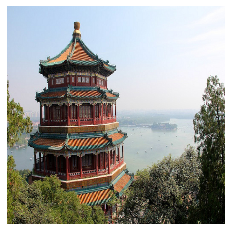

In [7]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

<style>
figure.img2{
  max-width: 80%;
  margin: 0 auto;
  width: content;
}

TD.leftcol {
width: 110px; /* Ширина левой колонки с рисунком */
vertical-align: top; /* Выравнивание по верхнему краю */
}
</style>

<table width="100%" cellspacing="0" cellpadding="0">
   <tr> 
    <td class="leftcol">
    <figure class="img2">
      <img 
      src="./images/book/monk.png"
      alt="">
    </figure>
    </td>
    <td valign="top" style="margin-left: 100px">Функция tf.image.resize() не сохранит соотношение сторон. Если это проблема, попробуйте обрезать изображения до нужного соотношения сторон перед изменением размера. Обе операции можно выполнить за один раз с помощью tf.image.crop_and_resize(). </tr>
</table>


Рассмотрим примеры других функций TensorFlow для изменения размера изображения:

Первая функция `tf.image.resize_with_pad` - это изменение размера изображения с равномерным добавлением нулей, для сохранения соотношения сторон. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


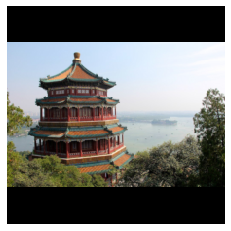

In [8]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

Вторая функция `tf.image.resize_with_crop_or_pad` - это изменение размера изображения до заданной ширины и высоты, обрезая изображение по центру или равномерно заполняет его нулями. Если ширина или высота исходного изображения больше, чем указано, то данная функция обрежит изображение по центру по заданному измерению. 

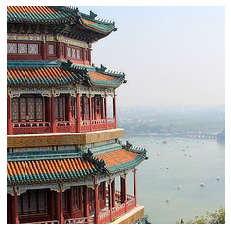

In [12]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

Третья функция `tf.image.crop_and_resize` - это извлечение обрезков из входного изображения и изменение его размерности, где аргументами функции явлюяются:
- image - исходное изображение.
- boxes - координаты блока(фрагмента), на исходном изображении, по которым будет обрезаться изображение. Задаются в нормализованных координат [y1, x1, y2, x2]. 
- box_indices - Данные значения(индексы) указывают на изображения (мини-пакет), к которым будет применяться обрезка, в том порядке в котором мы задали boxes. Колличество данных должно соотвестовать, колличеству фрагментов. 
- crop_size - Требуемая высота и ширина. Все фрагменты обрезанных изображений изменяются до этого размера. Соотношение сторон содержимого изображения не сохраняется.

На выходе будет четырехмерный тезор: [Колличесвто извлеченных фрагментов, Требуемая высота, Требуемая ширина, Каналы]. 

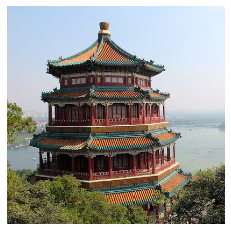

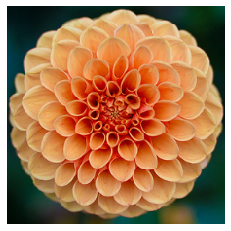

In [40]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0,1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

Предварительно обученные модели предполагают, что изображения предварительно обрабатываются определенным образом. В некоторых случаях они могут ожидать, что входные данные будут масштабироваться от 0 до 1 или от –1 до 1 и так далее.
Каждая модель предоставляет функцию preprocess_input(), которую вы можете использовать для предварительной обработки ваших изображений. Эти функции предполагают, что значения пикселей находятся в диапазоне от 0 до 255, поэтому мы должны умножить их на 255 (поскольку ранее мы масштабировали их до диапазона 0 до 1):

In [43]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

Теперь мы можем использовать предварительно обученную модель для прогнозирования:

In [44]:
Y_proba = model.predict(inputs)
Y_proba.shape

1/1 [==============================] - 0s 32ms/step


(2, 1000)

Как обычно, выход `Y_proba` представляет собой матрицу с одной строкой на изображение и одним столбцом на класс (в данном случае имеется 1000 классов). Если вы хотите отобразить $K$ лучших прогнозов, включая имя класса и предполагаемую вероятность каждого прогнозируемого класса, используйте функцию `decode_predictions()`. Для каждого изображения он возвращает массив, содержащий $K$ лучших прогнозов, где каждый прогноз представлен в виде массива, содержащего идентификатор класса, его имя и соответствующий показатель достоверности:

In [56]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f"Image #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f"  {class_id} - {name:12s}  {y_proba * 100:.2f}%")
    print()

Image #0
  n03877845 - palace        43.39%
  n02825657 - bell_cote     43.07%
  n03781244 - monastery     11.70%

Image #1
  n04522168 - vase          53.96%
  n07930864 - cup           9.52%
  n11939491 - daisy         4.97%



Правильные классы (монастырь и маргаритка) появляются в первых трех результатах для обоих изображений. Это неплохо, учитывая, что модель должна была выбирать из 1000 классов.

Как видите, очень легко создать довольно хороший классификатор изображений, используя предварительно обученную модель. Другие модели машинного зрения доступны в `keras.applications`, включают несколько вариантов ResNet, варианты GoogLeNet, такие как Inception-v3 и Xception, варианты VGGNet, а также MobileNet и MobileNetV2 (облегченные модели для использования в мобильных приложениях).

Но что, если вы хотите использовать классификатор изображений для классов изображений, которые не являются частью ImageNet? В этом случае вы все равно можете воспользоваться предварительно обученными моделями для выполнения трансферного обучения.

# Предварительно обученные модели для трансферного обучения

Если вы хотите построить классификатор изображений, но у вас недостаточно данных для обучения, часто бывает полезно повторно использовать нижние слои предварительно обученной модели, как мы обсуждали в главе 11. Например, давайте обучим модель классифицировать изображения цветов, повторно используя предварительно обученную модель Xception. Во-первых, давайте загрузим набор данных, используя наборы данных TensorFlow:

In [2]:
import tensorflow_datasets as tfds
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

d:\anaconda3\envs\tf39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
info.splits

{'train': <SplitInfo num_examples=3670, num_shards=2>}

In [4]:
info.splits["train"]

<SplitInfo num_examples=3670, num_shards=2>

In [5]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [6]:
n_classes = info.features["label"].num_classes
n_classes

5

In [7]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

Обратите внимание, что вы можете получить информацию о наборе данных, установив `with_info=True`. Здесь мы получаем размер набора данных и имена классов. К сожалению, есть только набор данных для обучения, а не тестовый или проверочный набор, поэтому нам нужно разделить обучающий набор. Проект TF Datasets предоставляет API для этого. Например, возьмем первые 10 % набора данных для тестирования, следующие 15 % для проверки и оставшиеся 75 % для обучения:

In [8]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

Отобразим первых восемь изображений:

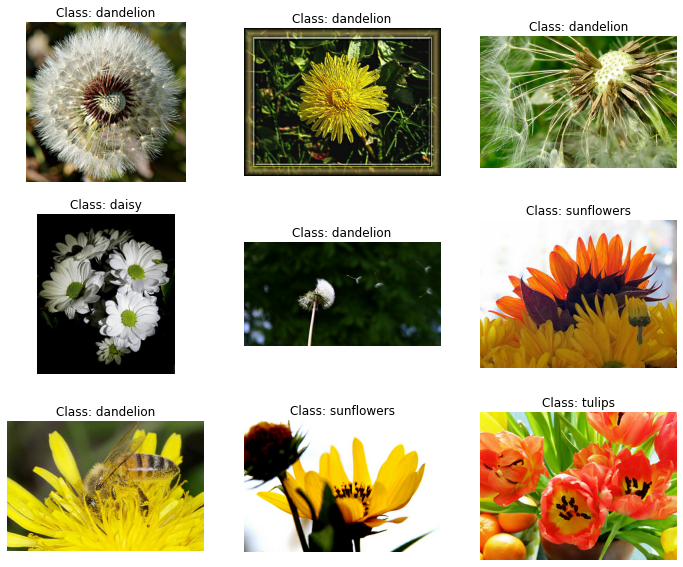

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
for index, (image, label) in enumerate(train_set_raw.take(9),start=1):
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

Далее мы должны предварительно обработать изображения. CNN ожидает изображения размером 224 × 224, поэтому нам нужно изменить их размер. Нам также нужно запустить изображения через функцию Xception `preprocess_input()`:

In [30]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

Если вы хотите выполнить некоторую аугментацию данных, измените функцию предварительной обработки для обучающего набора, добавив некоторые случайные преобразования к обучающим изображениям, то используйте `tf.image.random_crop()` для случайной обрезки изображений и `tf.image.random_flip_left_right()` для произвольного отражения изображений по горизонтали и т. д.

Немного более сложная предварительная обработка (но вы можете добавить гораздо больше данных):

In [10]:
# Обрезаем изображение по центру
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

#Обрезаем 90% изображения одинаковой размерности рандомно
def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

#Предварительная обработка изображения
def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        # С вероятностью 1 к 2 выводит изображение, 
        # перевернутое по второму измерению, то есть width.
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

Давайте применим эту функцию предварительной обработки ко всем трем наборам данных, перемешаем обучающий набор и добавим пакетную обработку и предварительную выборку ко всем наборам данных:

In [76]:
import tensorflow as tf
from tensorflow import keras
from functools import partial
batch_size = 32
#случайным образом перемешаем набор данных
train_set = train_set_raw.shuffle(1000).repeat()
# Предварительно обработаем данные (изображения)
# Сделаем так, чтобы каждый набор данных имел 32 мини-пакета(изображения), а не одно
# Предварительная выборка по 1 элементу (1 пакет по 32 примера), 
# позволяет подготовить более поздние элементы во время обработки текущего элемента.
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

Отобразим 1-й мини-пакет тренировачных изображений

Размерность мини-пакета(колличество изображений), высота, ширина и каналы: (32, 224, 224, 3)
Индексы правильных результатов, для каждого изоражения (32,)


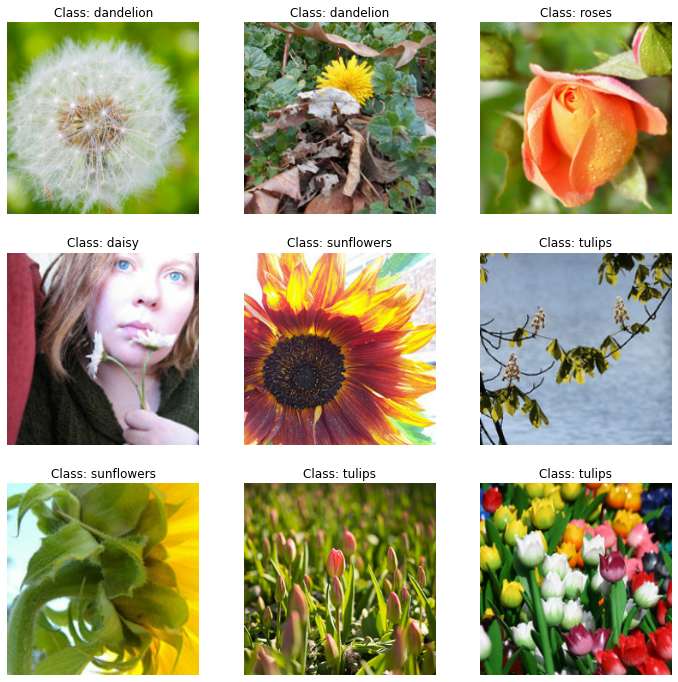

In [105]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    print("Размерность мини-пакета(колличество изображений), высота, ширина и каналы:",end=' ')
    print(X_batch.shape)
    print("Индексы правильных результатов, для каждого изоражения", end =" ")
    print(y_batch.shape)
    for index in range(9): # берем первых 9-ть изображений
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] /2 + 0.5) # Изменим интенсивность пикселей изображения от 0 до 1
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

Отобразим 1-й мини-пакет тестовых изображений

Размерность мини-пакета(колличество изображений), высота, ширина и каналы: (32, 224, 224, 3)
Индексы правильных результатов, для каждого изоражения (32,)


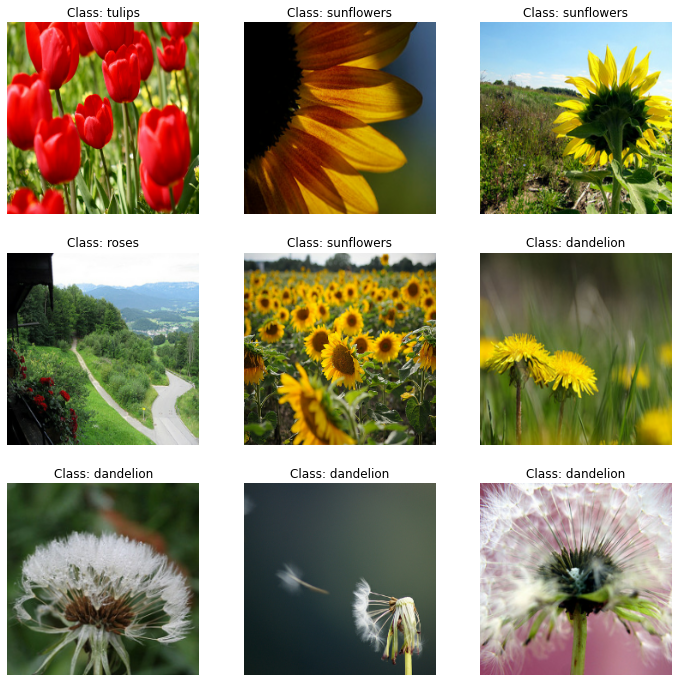

In [111]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    print("Размерность мини-пакета(колличество изображений), высота, ширина и каналы:",end=' ')
    print(X_batch.shape)
    print("Индексы правильных результатов, для каждого изоражения", end =" ")
    print(y_batch.shape)
    for index in range(9): # берем первых 9-ть изображений
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] /2 + 0.5) # Изменим интенсивность пикселей изображения от 0 до 1
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

<style>
figure.img2{
  max-width: 80%;
  margin: 0 auto;
  width: content;
}

TD.leftcol {
width: 110px; /* Ширина левой колонки с рисунком */
vertical-align: top; /* Выравнивание по верхнему краю */
}
</style>

<table width="100%" cellspacing="0" cellpadding="0">
   <tr> 
    <td class="leftcol">
    <figure class="img2">
      <img 
      src="./images/book/monk.png"
      alt="">
    </figure>
    </td>
    <td valign="top" style="margin-left: 100px"> Класс <code>keras.preprocessing.image.ImageDataGenerator</code> позволяет легко загружать изображения с диска и дополнять их различными способами: вы можете сдвигать каждое изображение, поворачивать его, масштабировать, отражать по горизонтали или вертикали, срезать или примените к нему любую функцию преобразования. Это очень удобно для простых проектов. Однако создание конвейера <code>tf.data</code> имеет много преимуществ: он может эффективно считывать изображения (например, параллельно) из любого источника, а не только с локального диска; вы можете манипулировать набором данных по своему усмотрению; и если вы напишете функцию предварительной обработки на основе операций <code>tf.image</code>, эту функцию можно будет использовать как в конвейере <code>tf.data</code>, так и в модели, которую вы будете развертывать в рабочей среде (см. главу 19).</tr>
</table>


Далее давайте загрузим модель Xception, предварительно обученную в ImageNet. Мы исключаем верхнюю часть сети, устанавливая include_top=False: это исключает слой глобального объединения по среднему и плотный выходной слой. Затем мы добавляем наш собственный слой глобального объединения по среднему на основе выходных данных базовой модели, за которым следует плотный выходной слой с одним модулем на класс, используя функцию активации softmax. Наконец, мы создаем модель Keras:

In [21]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(5, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [196]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_15
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_56
13 block2_pool
14 batch_normalization_56
15 add_168
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_57
23 block3_pool
24 batch_normalization_57
25 add_169
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_58
33 block4_pool
34 batch_normalization_58
35 add_170
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_171
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
5

Как объяснялось в главе 11, обычно рекомендуется заморозить веса предварительно обученных слоев, по крайней мере, в начале обучения:

In [144]:
for layer in base_model.layers:
    layer.trainable = False

<style>
figure.img2{
  max-width: 80%;
  margin: 0 auto;
  width: content;
}

TD.leftcol {
width: 110px; /* Ширина левой колонки с рисунком */
vertical-align: top; /* Выравнивание по верхнему краю */
}
</style>

<table width="100%" cellspacing="0" cellpadding="0">
   <tr> 
    <td class="leftcol">
    <figure class="img2">
      <img 
      src="./images/book/bird.png"
      alt="">
    </figure>
    </td>
    <td valign="top" style="margin-left: 100px"> Поскольку наша модель использует слои базовой модели напрямую, а не сам объект base_model, установка base_model.trainable=False не будет иметь никакого эффекта. </tr>
</table>


Наконец, мы можем скомпилировать модель и начать обучение:

In [146]:
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 49s 461ms/step - loss: 1.5889 - accuracy: 0.7896 - val_loss: 1.5833 - val_accuracy: 0.8199
Epoch 2/5
86/86 [==============================] - 34s 393ms/step - loss: 0.6637 - accuracy: 0.8870 - val_loss: 0.8434 - val_accuracy: 0.8676
Epoch 3/5
86/86 [==============================] - 34s 398ms/step - loss: 0.3571 - accuracy: 0.9259 - val_loss: 0.8570 - val_accuracy: 0.8676
Epoch 4/5
86/86 [==============================] - 34s 396ms/step - loss: 0.2484 - accuracy: 0.9448 - val_loss: 0.8176 - val_accuracy: 0.8621
Epoch 5/5
86/86 [==============================] - 34s 396ms/step - loss: 0.2044 - accuracy: 0.9459 - val_loss: 0.7545 - val_accuracy: 0.8750


Оценим нашу модель

In [147]:
score = model.evaluate(test_set)

12/12 [==============================] - 5s 352ms/step - loss: 0.6384 - accuracy: 0.8965


Генерируем прогнозы для 367 образцов

In [53]:
y_proba_new = model.predict(test_set)
y_proba_new.shape


92/92 [==============================] - 5s 58ms/step


(367, 5)

Посмотрим прогнозы для трех образцов 

In [175]:
new_out = y_proba_new[0:3]

for i in range(new_out.shape[0]):    
    print(f"Image #{i}")
    print(f"{class_names[np.argmax(new_out[i])]:12s}  { np.max(new_out[i]) * 100:.2f}%")


Image #0
tulips        100.00%
Image #1
sunflowers    100.00%
Image #2
sunflowers    91.30%


Отобразим изображения и сверим их

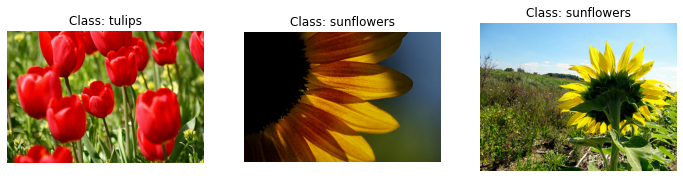

In [178]:
plt.figure(figsize=(12, 10))
for index, (image, label) in enumerate(test_set_raw.take(3),start=1):
    plt.subplot(1, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

<style>
figure.img2{
  max-width: 80%;
  margin: 0 auto;
  width: content;
}

TD.leftcol {
width: 110px; /* Ширина левой колонки с рисунком */
vertical-align: top; /* Выравнивание по верхнему краю */
}
</style>

<table width="100%" cellspacing="0" cellpadding="0">
   <tr> 
    <td class="leftcol">
    <figure class="img2">
      <img 
      src="./images/book/scor.png"
      alt="">
    </figure>
    </td>
    <td valign="top" style="margin-left: 100px"> Это будет очень медленно, если у вас нет графического процессора. Если вы этого не сделаете, вам следует запустить записную книжку этой главы в Colab, используя среду выполнения GPU (это бесплатно!).</tr>
</table>


После обучения модели в течение нескольких эпох точность ее проверки должна достичь примерно 75–80% и перестать делать большой прогресс. Это означает, что верхние слои теперь довольно хорошо обучены, поэтому мы готовы разморозить все слои (или вы можете попробовать разморозить только верхние) и продолжить обучение (не забудьте скомпилировать модель, когда вы замораживаете или размораживаете слои). На этот раз мы используем гораздо более низкую скорость обучения, чтобы не повредить предварительно обученные веса:

In [43]:
batch_size = 4
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [44]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(5, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [45]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
688/688 [==============================] - 192s 273ms/step - loss: 0.6974 - accuracy: 0.7515 - val_loss: 0.4852 - val_accuracy: 0.8321
Epoch 2/5
688/688 [==============================] - 189s 275ms/step - loss: 0.3725 - accuracy: 0.8746 - val_loss: 0.3032 - val_accuracy: 0.8905
Epoch 3/5
688/688 [==============================] - 191s 278ms/step - loss: 0.2212 - accuracy: 0.9233 - val_loss: 0.2640 - val_accuracy: 0.9142
Epoch 4/5
688/688 [==============================] - 191s 278ms/step - loss: 0.1617 - accuracy: 0.9448 - val_loss: 0.2677 - val_accuracy: 0.9270
Epoch 5/5
688/688 [==============================] - 191s 278ms/step - loss: 0.1191 - accuracy: 0.9626 - val_loss: 0.2714 - val_accuracy: 0.9142


Оценим нашу модель

In [48]:
score = model.evaluate(test_set)

92/92 [==============================] - 6s 58ms/step - loss: 0.2240 - accuracy: 0.9319


Генерируем прогнозы для 367 образцов

In [50]:
y_proba_new = model.predict(test_set)

92/92 [==============================] - 6s 58ms/step


Посмотрим прогнозы для трех образцов 

In [55]:
import numpy as np
new_out = y_proba_new[0:3]

for i in range(new_out.shape[0]):    
    print(f"Image #{i}")
    print(f"{class_names[np.argmax(new_out[i])]:12s}  { np.max(new_out[i]) * 100:.2f}%")


Image #0
tulips        99.98%
Image #1
sunflowers    99.56%
Image #2
sunflowers    99.70%


Отобразим изображения и сверим их

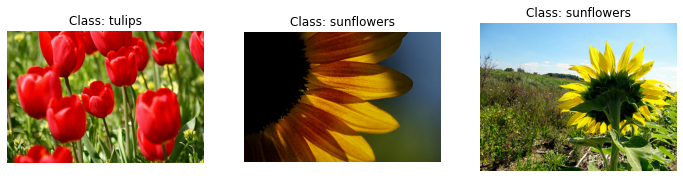

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
for index, (image, label) in enumerate(test_set_raw.take(3),start=1):
    plt.subplot(1, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

Это займет некоторое время, но эта модель должна достичь точности около 93% на тестовом наборе при пяти эпохах. 
С этим вы можете начать обучение удивительным классификаторам изображений! Но компьютерное зрение — это нечто большее, чем просто классификация. Например, что, если вы также хотите знать, где находится цветок на картинке? Давайте посмотрим на это сейчас.

# Классификация и локализация

Локализация объекта на изображении может быть выражена как задача регрессии, как обсуждалось в главе 10: чтобы предсказать ограничивающую рамку вокруг объекта, общий подход состоит в том, чтобы предсказать горизонтальные и вертикальные координаты центра объекта, а также его высоту и ширину. Это означает, что у нас есть четыре числа для предсказания. Модель не требует больших изменений; нам просто нужно добавить второй плотный выходной слой с четырьмя единицами (обычно поверх глобального среднего объединяющего слоя), и его можно обучить, используя потери MSE:

In [151]:
import tensorflow as tf
from tensorflow import keras

base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

Но теперь у нас есть проблема: набор данных цветов не имеет ограничивающих рамок вокруг цветов. Значит, нам нужно добавить их самим. Часто это одна из самых сложных и дорогостоящих частей проекта машинного обучения: получение меток. Лучше потратить время на поиск нужных инструментов. Чтобы аннотировать изображения с помощью ограничительных рамок, вы можете использовать инструмент маркировки изображений с открытым исходным кодом, такой как VGG Image Annotator, LabelImg, OpenLabeler или ImgLab, или, возможно, коммерческий инструмент, такой как LabelBox или Supervisely. Вы также можете рассмотреть возможность использования краудсорсинговых платформ, таких как Amazon Mechanical Turk, если у вас есть очень большое количество изображений для аннотирования. Тем не менее, создание краудсорсинговой платформы, подготовка формы для отправки работникам, надзор за ними и обеспечение хорошего качества ограничивающих рамок, которые они производят, требует большого объема работы, поэтому убедитесь, что это того стоит. Если нужно пометить всего несколько тысяч изображений и вы не планируете делать это часто, может быть предпочтительнее сделать это самостоятельно. Адриана Ковашка и др. написали очень практическую статью о краудсорсинге в компьютерном зрении. Я рекомендую вам ознакомиться с ним, даже если вы не планируете использовать краудсорсинг.

Создадим функцию для получения ограничивающей рамки для каждого изображения в наборе данных цветов. Каждый набор данных должен быть кортежем формы (images, (class_labels,bounding_boxes)).   

In [125]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4]) #(Размерность мини-пакета,4)
    return images, (labels, fake_bboxes)

Затем вам нужно создать набор данных, элементами которого будут пакеты предварительно обработанных изображений вместе с их метками классов и ограничивающими рамками.

In [152]:
batch_size = 6
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)
fake_train_set = train_set.take(26).repeat(2).map(add_random_bounding_boxes)

Мы готовы обучить нашу модель.

In [153]:
for layer in base_model.layers:
    layer.trainable = True
history = model.fit(fake_train_set, steps_per_epoch=52, epochs=10)

Epoch 1/10
52/52 [==============================] - 23s 343ms/step - loss: 0.9646 - dense_8_loss: 1.1617 - dense_9_loss: 0.1763 - dense_8_accuracy: 0.5737 - dense_9_accuracy: 0.2532
Epoch 2/10
52/52 [==============================] - 19s 345ms/step - loss: 0.5737 - dense_8_loss: 0.6827 - dense_9_loss: 0.1375 - dense_8_accuracy: 0.7756 - dense_9_accuracy: 0.2500
Epoch 3/10
52/52 [==============================] - 19s 348ms/step - loss: 0.4401 - dense_8_loss: 0.5195 - dense_9_loss: 0.1227 - dense_8_accuracy: 0.8013 - dense_9_accuracy: 0.2372
Epoch 4/10
52/52 [==============================] - 19s 352ms/step - loss: 0.3695 - dense_8_loss: 0.4317 - dense_9_loss: 0.1205 - dense_8_accuracy: 0.8269 - dense_9_accuracy: 0.2436
Epoch 5/10
52/52 [==============================] - 19s 356ms/step - loss: 0.3120 - dense_8_loss: 0.3622 - dense_9_loss: 0.1113 - dense_8_accuracy: 0.8654 - dense_9_accuracy: 0.2083
Epoch 6/10
52/52 [==============================] - 19s 356ms/step - loss: 0.2842 - dense_

Оценим нашу модель

In [158]:
fake_test_set = test_set.take(1).map(add_random_bounding_boxes)
score = model.evaluate(fake_test_set)


1/1 [==============================] - 0s 441ms/step - loss: 0.2753 - dense_8_loss: 0.3041 - dense_9_loss: 0.1604 - dense_8_accuracy: 0.8333 - dense_9_accuracy: 0.3333


<style>
figure.img2{
  max-width: 80%;
  margin: 0 auto;
  width: content;
}

TD.leftcol {
width: 110px; /* Ширина левой колонки с рисунком */
vertical-align: top; /* Выравнивание по верхнему краю */
}
</style>

<table width="100%" cellspacing="0" cellpadding="0">
   <tr> 
    <td class="leftcol">
    <figure class="img2">
      <img 
      src="./images/book/monk.png"
      alt="">
    </figure>
    </td>
    <td valign="top" style="margin-left: 100px"> Ограничительные рамки должны быть нормализованы так, чтобы горизонтальные и вертикальные координаты, а также высота и ширина находились в диапазоне от 0 до 1. Кроме того, обычно предсказывают квадратный корень из высоты и ширины, а не непосредственно высоту и ширину: таким образом, 10-пиксельная ошибка для большой ограничивающей рамки не будет наказываться так сильно, как 10-пиксельная ошибка для маленькой ограничивающей рамки.</tr>
</table>


MSE часто работает довольно хорошо в качестве функции стоимости для обучения модели, но это не лучший показатель для оценки того, насколько хорошо модель может предсказывать ограничивающие рамки. Наиболее распространенной метрикой для этого является Intersection over Union (IoU): площадь перекрытия между прогнозируемой ограничивающей рамкой и целевой ограничивающей рамкой, деленная на площадь их объединения (см. рис. 14-23). В tf.keras это реализуется классом `tf.keras.metrics.MeanIoU`.


<style>
figure.img {
  max-width: 50%;
  margin: 0 auto;
  text-align: center;
  width: content; 

}
figure.img figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
</style> 

<figure class="img">
    <img 
    src="./images/book/img23.png"
    alt="">
    <figcaption>
    Рис 14-23. Метрика Intersection over Union (IoU) для ограничивающих рамок.    
    </figcaption>
</figure>

Классифицировать и локализовать один объект — это хорошо, но что, если изображения содержат несколько объектов (как это часто бывает в наборе данных о цветах)?

# Обнаружение объекта

Задача классификации и локализации нескольких объектов на изображении называется обнаружением объектов. Еще несколько лет назад общепринятым подходом было взять CNN, обученную классифицировать и определять местонахождение одного объекта, а затем перемещать ее по изображению, как показано на рис. 14-24. В этом примере изображение было разбито на сетку 6 × 8, и мы показываем CNN (толстый черный прямоугольник), скользящий по всем областям 3 × 3. Когда CNN смотрела на верхний левый угол изображения, она обнаружила часть самой левой розы, а затем снова обнаружила ту же самую розу, когда она была впервые сдвинута на один шаг вправо. На следующем шаге он начал обнаруживать часть самой верхней розы, а затем обнаруживал ее снова, как только она была смещена еще на один шаг вправо. Затем вы продолжите перемещать CNN по всему изображению, просматривая все области 3 × 3. Более того, поскольку объекты могут иметь разные размеры, вы также будете перемещать CNN по областям разных размеров. Например, после того, как вы закончите с областями 3 × 3, вы можете захотеть провести CNN по всем областям 4 × 4.


<style>
figure.img {
  max-width: 50%;
  margin: 0 auto;
  text-align: center;
  width: content; 

}
figure.img figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
</style> 

<figure class="img">
    <img 
    src="./images/book/img24.png"
    alt="">
    <figcaption>
    Рис 14-24. Обнаружение нескольких объектов путем скольжения CNN по изображению.    
    </figcaption>
</figure>

Этот метод довольно прост, но, как вы можете видеть, он будет обнаруживать один и тот же объект несколько раз в немного разных положениях. Затем потребуется некоторая постобработка, чтобы избавиться от всех ненужных ограничивающих рамок. Обычный подход для этого называется немаксимальным подавлением. Вот как это сделать:

1. Во-первых, вам нужно добавить дополнительный вывод объектности в вашу CNN, чтобы оценить вероятность того, что цветок действительно присутствует на изображении (в качестве альтернативы вы можете добавить класс «без цветов», но это обычно не работает). Он должен использовать `sigmoid` функцию активации, и вы можете обучить его, используя функцию потерь `BinaryCrossentropy`. Затем избавьтесь от всех ограничивающих рамок, для которых оценка объектности ниже некоторого порога: это удалит все ограничивающие рамки, которые на самом деле не содержат цветок.

2. Найдите ограничивающую рамку с наивысшей оценкой объектности и избавьтесь от всех других ограничивающих рамок, которые сильно пересекаются с ней (например, с IoU более 60%). Например, на рис. 14.24 ограничивающая рамка с максимальной оценкой объектности — это толстая ограничивающая рамка над самой верхней розой (оценка объектности представлена толщиной ограничивающих рамок). Другая ограничивающая рамка над той же розой сильно перекрывается с максимальной ограничивающей рамкой, поэтому мы избавимся от нее.

3. Повторяйте второй шаг, пока не останется ограничивающих рамок, от которых нужно избавиться.

Этот простой подход к обнаружению объектов работает довольно хорошо, но требует многократного запуска CNN, поэтому он довольно медленный. К счастью, есть гораздо более быстрый способ скользить CNN по изображению: использование полностью сверточной сети (FCN).


# Полностью сверточные сети

Идея FCN была впервые представлена в статье Джонатана Лонга и др. в 2015 году для семантической сегментации (задачи классификации каждого пикселя изображения в соответствии с классом объекта, к которому он принадлежит). Авторы указали, что вы можете заменить плотные слои в верхней части CNN сверточными слоями. Чтобы понять это, давайте рассмотрим пример: предположим, что плотный слой с 200 нейронами расположен поверх сверточного слоя, который выводит 100 карт признаков, каждая размером 7 × 7 (это размер карты признаков, а не размер ядра). Каждый нейрон будет вычислять взвешенную сумму всех 100 × 7 × 7 активаций из сверточного слоя (плюс смещение bias). Теперь давайте посмотрим, что произойдет, если мы заменим плотный слой сверточным слоем, используя 200 фильтров, каждый размером 7 × 7, и с дополнением «valid». Этот слой выведет 200 карт признаков, каждая 1 × 1 (поскольку размер ядра точно соответствует размеру входных карт признаков, и мы используем дополнение «valid»). Другими словами, он выведет 200 чисел, как это сделал плотный слой; и если вы внимательно посмотрите на вычисления, выполняемые сверточным слоем, вы заметите, что эти числа будут в точности такими же, как те, которые произвел плотный слой. Единственное отличие состоит в том, что на выходе плотного слоя был тензор формы [размер пакета, 200], а сверточный слой выдает тензор формы [размер пакета, 1, 1, 200].

<style>
figure.img2{
  max-width: 80%;
  margin: 0 auto;
  width: content;
}

TD.leftcol {
width: 110px; /* Ширина левой колонки с рисунком */
vertical-align: top; /* Выравнивание по верхнему краю */
}
</style>

<table width="100%" cellspacing="0" cellpadding="0">
   <tr> 
    <td class="leftcol">
    <figure class="img2">
      <img 
      src="./images/book/monk.png"
      alt="">
    </figure>
    </td>
    <td valign="top" style="margin-left: 100px"> Чтобы преобразовать плотный слой в сверточный, количество фильтров в сверточном слое должно быть равно количеству единиц в плотном слое, размер фильтра должен быть равен размеру входных карт признаков, и вы должны использовать дополнение «valid». Stride может быть установлен равным 1 или больше, как мы вскоре увидим.</tr>
</table>

Почему это важно? Хорошо, в то время как плотный слой ожидает определенного входного размера (поскольку он имеет один вес для каждой входной функции), сверточный слой с радостью обработает изображения любого размера (однако он ожидает, что его входы будут иметь определенное количество каналов, поскольку каждое ядро содержит разный набор весов для каждого входного канала). Поскольку FCN содержит только сверточные слои (и объединяющие слои, обладающие тем же свойством), его можно обучать и выполнять на изображениях любого размера!

Например, предположим, что мы уже обучили CNN классификации и локализации цветов. Он был обучен на изображениях 224 × 224 и выводит 10 чисел: выходные данные от 0 до 4 отправляются через функцию активации softmax, и это дает вероятности классов (по одной на класс); выход 5 отправляется через функцию логистической активации, и это дает оценку объектности; выходы с 6 по 9 не используют никаких функций активации, и они представляют координаты центра ограничивающей рамки, а также ее высоту и ширину. Теперь мы можем преобразовать его плотные слои в сверточные слои. На самом деле нам даже не нужно его переучивать; мы можем просто скопировать веса из плотных слоев в сверточные слои! В качестве альтернативы мы могли бы преобразовать CNN в FCN перед тренировкой.

Теперь предположим, что последний сверточный слой перед выходным слоем (также называемый слоем узкого места) выводит карты признаков 7 × 7, когда в сеть подается изображение 224 × 224 (см. левую часть рис. 14-25). Если мы подадим в FCN изображение размером 448 × 448 (см. правую часть рисунка 14-25), слой узкого места теперь будет выводить карты признаков размером 14 × 14. Поскольку плотный выходной слой был заменен сверточным слоем с использованием 10 фильтров размером 7 × 7 с «valid» дополнением и stride 1, выходные данные будут состоять из 10 карт признаков, каждая из которых имеет размер 8 × 8 (поскольку 14 – 7 + 1 = 8). Другими словами, FCN обработает все изображение только один раз и выведет сетку 8 × 8, где каждая ячейка содержит 10 чисел (5 вероятностей классов, 1 показатель объектности и 4 координаты ограничивающего прямоугольника). Это точно так же, как взять исходную CNN и сдвинуть ее по изображению, используя 8 шагов на строку и 8 шагов на столбец. Чтобы визуализировать это, представьте, что исходное изображение разрезается на сетку 14 × 14, а затем перемещается окно 7 × 7 по этой сетке; будет 8 × 8 = 64 возможных местоположения окна, следовательно, 8 × 8 предсказаний. Однако подход FCN намного эффективнее, поскольку сеть просматривает изображение только один раз. На самом деле You Only Look Once (YOLO) — это название очень популярной архитектуры обнаружения объектов, которую мы рассмотрим далее.

<style>
figure.img {
  max-width: 50%;
  margin: 0 auto;
  text-align: center;
  width: content; 

}
figure.img figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
</style> 

<figure class="img">
    <img 
    src="./images/book/img25.png"
    alt="">
    <figcaption>
    Рис 14-25. Одна и та же полностью сверточная сеть, обрабатывающая маленькое изображение (слева) и большое (справа).    
    </figcaption>
</figure>

# You Only Look Once (YOLO)

YOLO — это чрезвычайно быстрая и точная архитектура обнаружения объектов, предложенная Джозефом Редмоном и др. в статье 2015 года и впоследствии улучшенная в 2016 году (YOLOv2) и в 2018 году (YOLOv3). Он настолько быстр, что может работать в режиме реального времени на видео, как видно из демонстрации Redmon.

Архитектура YOLOv3 очень похожа на ту, которую мы только что обсуждали, но с несколькими важными отличиями:

- Он выводит пять ограничивающих рамок для каждой ячейки сетки (вместо одной), и каждая ограничивающая рамка имеет оценку объектности. Он также выводит 20 вероятностей классов на ячейку сетки, так как он был обучен на наборе данных PASCAL VOC, который содержит 20 классов. Всего на ячейку сетки приходится 45 чисел: 5 ограничивающих рамок, каждая с 4 координатами, плюс 5 оценок объектности, плюс 20 вероятностей классов.

- Вместо того, чтобы предсказывать абсолютные координаты центров ограничительной рамки, YOLOv3 предсказывает смещение относительно координат ячейки сетки, где (0, 0) означает верхнюю левую часть этой ячейки, а (1, 1) означает нижнюю правую. Для каждой ячейки сетки YOLOv3 обучен предсказывать только ограничивающие рамки, центр которых находится в этой ячейке (но сама ограничивающая рамка обычно выходит далеко за пределы ячейки сетки). YOLOv3 применяет функцию логистической активации к координатам ограничивающей рамки, чтобы они оставались в диапазоне от 0 до 1.

- Перед обучением нейронной сети YOLOv3 находит пять репрезентативных размеров ограничивающей рамки, называемых якорными рамками (или априорными размерами ограничивающей рамки). Это достигается путем применения алгоритма K-средних (см. главу 9) к высоте и ширине ограничивающих прямоугольников обучающего набора. Например, если обучающие изображения содержат много пешеходов, то один из блоков привязки, вероятно, будет иметь размеры типичного пешехода. Затем, когда нейронная сеть предсказывает пять ограничивающих прямоугольников на ячейку сетки, она фактически предсказывает, насколько масштабировать каждый из якорных прямоугольников. Например, предположим, что один блок привязки имеет высоту 100 пикселей и ширину 50 пикселей, и сеть предсказывает, скажем, коэффициент масштабирования по вертикали 1,5 и масштабирование по горизонтали 0,9 (для одной из ячеек сетки). Это приведет к прогнозируемой ограничивающей рамке размером 150 × 45 пикселей. Чтобы быть более точным, для каждой ячейки сетки и каждого поля привязки сеть прогнозирует логарифм вертикального и горизонтального коэффициентов масштабирования. Наличие этих априорных значений делает сеть более вероятной для предсказания ограничивающих рамок соответствующих размеров, а также ускоряет обучение, поскольку она быстрее узнает, как выглядят разумные ограничивающие рамки.

- Сеть обучается на изображениях разного масштаба: каждые несколько пакетов во время обучения сеть случайным образом выбирает новый размер изображения (от 330×330 до 608×608 пикселей). Это позволяет сети научиться обнаруживать объекты в разных масштабах. Кроме того, это позволяет использовать YOLOv3 в разных масштабах: меньший масштаб будет менее точным, но более быстрым, чем больший масштаб, поэтому вы можете выбрать правильный компромисс для своего варианта использования.

Есть еще несколько нововведений, которые могут вас заинтересовать, например, использование пропущенных соединений для восстановления некоторого пространственного разрешения, утраченного в CNN (мы вскоре обсудим это, когда будем рассматривать семантическую сегментацию). В статье 2016 года авторы представляют модель YOLO9000, которая использует иерархическую классификацию: модель предсказывает вероятность для каждого узла в визуальной иерархии под названием WordTree. Это позволяет сети с высокой степенью достоверности предсказывать, что изображение представляет, скажем, собаку, даже если неизвестно, какой конкретно тип собаки. Я призываю вас прочитать все три документа: их довольно приятно читать, и они предоставляют отличные примеры того, как можно постепенно улучшать системы глубокого обучения.

 <head>
  <style>
   .outline {
    border: 1px solid red;
    padding: 1px;
   } 
  </style>
 </head>
 <body>
  <div class="outline">
   <p><center><strong> </p> Mean Average Precision (mAP) - Средняя средняя точность </center> </strong>
   <p>Очень распространенной метрикой, используемой в задачах обнаружения объектов, является средняя средняя точность (mAP). «Среднее среднее» звучит несколько избыточно, не так ли? Чтобы понять эту метрику, давайте вернемся к двум метрикам классификации, которые мы обсуждали в главе 3: точность и полнота. Помните о компромиссе: чем выше полнота, тем ниже точность. Вы можете визуализировать это на кривой точность/полнота (см. рис. ниже). Чтобы суммировать эту кривую в одно число, мы могли бы вычислить ее площадь под кривой (AUC). Но обратите внимание, что кривая «точность/полнота» может содержать несколько участков, на которых точность фактически повышается при увеличении полноты, особенно при низких значениях полноты (вы можете видеть это в левом верхнем углу рис. ниже). Это одна из причин использования метрики mAP.</p>
   <p>Предположим, что классификатор имеет точность 90% при полноте 10%, но точность 96% при полноте 20%. Здесь действительно нет компромисса: просто имеет смысл использовать классификатор при 20%-й полноте, а не при 10%-й полноте, так как вы получите как более высокую полноту, так и более высокую точность. Таким образом, вместо того, чтобы смотреть на точность при 10%-й полноте, мы действительно должны смотреть на максимальную точность, которую может предложить классификатор при по крайней мере 10%-й полноте. Это будет 96%, а не 90%. Таким образом, один из способов получить четкое представление о производительности модели — вычислить максимальную точность, которую можно получить при полноте не менее 0 %, затем при полноте 10 %, 20 % и так далее до 100 %, а затем вычислить среднее значение этих максимальных точностей. Это называется метрикой средней точности (AP). Теперь, когда классов больше двух, мы можем вычислить AP для каждого класса, а затем вычислить среднее AP (mAP). Вот и все! </p>
   <p>В системе обнаружения объектов есть дополнительный уровень сложности: что, если система обнаружила правильный класс, но в неправильном месте (то есть ограничивающая рамка полностью отключена)? Конечно, мы не должны считать это положительным прогнозом. Один из подходов заключается в определении порога IOU: например, мы можем считать, что прогноз верен, только если IOU больше, скажем, 0.5, а предсказанный класс верен. Соответствующий mAP обычно обозначается mAP@0.5 (или mAP@50%, а иногда просто AP50). В некоторых соревнованиях (таких как PASCAL VOC challenge) так и делается. В других случаях (таких как соревнование COCO) mAP вычисляется для различных пороговых значений IOU (0.50, 0.55, 0.60, …, 0.95), а конечным показателем является среднее значение всех этих mAP (отмечено как AP@[.50:.95] или AP@[.50:0.05:0,95]). Да, это среднее среднее. </p>
</div>
 </body>

**Визуализация Mean Average Precision (mAP)**

In [1]:
# Оставляем только максимальные точности
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

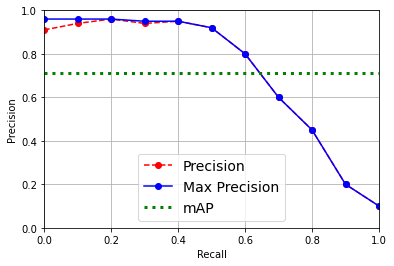

In [15]:
import numpy as np
import matplotlib.pyplot as plt

recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center", fontsize=14)
plt.show()

Несколько реализаций YOLO, созданных с использованием TensorFlow, доступны на GitHub. В частности, ознакомьтесь с реализацией TensorFlow 2 Zihao Zang. Другие модели обнаружения объектов доступны в проекте TensorFlow Models, многие из которых имеют предварительно обученные веса; а некоторые даже были перенесены на TF Hub, например, SSD и Faster-RCNN, которые довольно популярны. SSD также является моделью обнаружения «одиночного выстрела», аналогичной YOLO. Более быстрая R-CNN более сложна: изображение сначала проходит через CNN, затем выходные данные передаются в сеть региональных предложений (RPN), которая предлагает ограничивающие рамки, которые, скорее всего, содержат объект, и для каждой ограничивающей рамки запускается классификатор на основе обрезанного вывода CNN.

Выбор системы обнаружения зависит от многих факторов: скорости, точности, наличия предварительно обученных моделей, времени обучения, сложности и т.д. Документы содержат таблицы метрик, но в средах тестирования довольно много вариаций, а технологии развиваются так быстро, что трудно провести справедливое сравнение, которое было бы полезно для большинства людей и оставались бы действительными для более чем несколько месяцев. 

Таким образом, мы можем находить объекты, рисуя вокруг них ограничивающие рамки. Отлично! Но, возможно, вы хотите быть немного более точным. Давайте посмотрим, как перейти на уровень пикселей.

# Семантическая сегментация

При семантической сегментации каждый пиксель классифицируется в соответствии с классом объекта, к которому он принадлежит (например, дорога, автомобиль, пешеход, здание и т. д.), как показано на рис. 14-26. Обратите внимание, что разные объекты одного класса не различаются. Например, все велосипеды в правой части сегментированного изображения в конечном итоге представляют собой один большой кусок пикселей. Основная сложность в этой задаче заключается в том, что при прохождении изображений через обычную CNN они постепенно теряют свое пространственное разрешение (из-за слоев с шагом больше 1); Таким образом, обычная CNN может в конечном итоге узнать, что где-то в левом нижнем углу изображения есть человек, но это не будет намного более точным.

Как и в случае с обнаружением объектов, существует множество различных подходов к решению этой проблемы, некоторые из которых довольно сложны. Однако довольно простое решение было предложено в статье 2015 года Джонатана Лонга и др., которую мы обсуждали ранее. Авторы начинают с того, что берут предварительно обученную CNN и превращают ее в FCN. CNN применяет к входному изображению общий шаг 32 (т. е. если вы суммируете все шаги больше 1), что означает, что последний слой выводит карты объектов, которые в 32 раза меньше, чем входное изображение. Это явно слишком грубо, поэтому они добавляют один слой повышающей дискретизации, который умножает разрешение на 32.

<style>
figure.img {
  max-width: 50%;
  margin: 0 auto;
  text-align: center;
  width: content; 

}
figure.img figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
</style> 

<figure class="img">
    <img 
    src="./images/book/img26.png"
    alt="">
    <figcaption>
    Рис 14-26. Семантическая сегментация.    
    </figcaption>
</figure>

Существует несколько решений для повышающей дискретизации (увеличения размера изображения), таких как билинейная интерполяция, но это работает достаточно хорошо только до ×4 или ×8. Вместо этого они используют транспонированный сверточный слой. Это эквивалентно сначала растягиванию изображения путем вставки пустых строк и столбцов (заполненных нулями), а затем выполнению обычной свертки (см. рис. 14.27). С другой стороны, некоторые люди предпочитают думать об этом как об обычном сверточном слое, в котором используются дробные шаги (например, 1/2 на рис. 14.27). Транспонированный сверточный слой можно инициализировать для выполнения чего-то близкого к линейной интерполяции, но, поскольку это обучаемый слой, во время обучения он научится работать лучше. В tf.keras можно использовать слой `Conv2DTranspose`.

<figure class="img">
    <img 
    src="./images/book/img27.png"
    alt="">
    <figcaption>
    Рис 14-27. Повышение частоты дискретизации с использованием транспонированного сверточного слоя.    
    </figcaption>
</figure>


**Пример использования транспонированного сверточного слоя:**

In [70]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])

import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(42)
images_resized = tf.image.resize(images, [224, 224])
X = images_resized.numpy()
print("Изначальный размер изображения: ",X.shape)

conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3, strides=2, padding="VALID")
output = conv_transpose(X)
print("Размер изображения с использованием транспонированного сверточного слоя:", output.shape)

Изначальный размер изображения:  (2, 224, 224, 3)
Размер изображения с использованием транспонированного сверточного слоя: (2, 449, 449, 5)


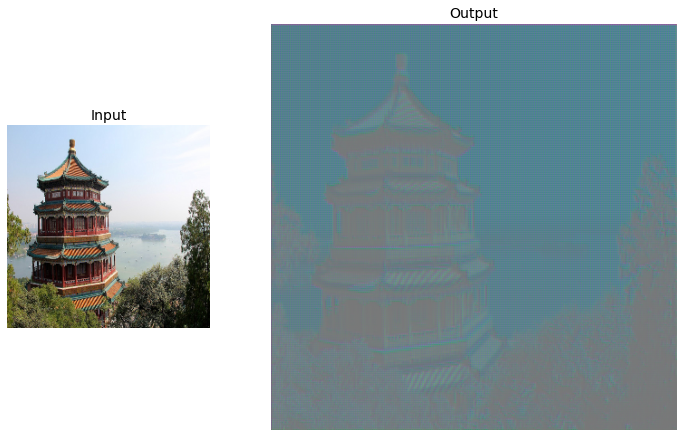

In [173]:
def normalize(X): # Нормализуем координаты в промежутке [0,1]
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(normalize(output[0, :,:, 0:3]), interpolation="bicubic")  # plot the output for the 1st image
ax2.axis("off")
plt.show()

In [66]:
def upscale_images(images, stride, kernel_size):
    batch_size, height, width, channels = images.shape
    upscaled = np.zeros((batch_size,
                         (height - 1) * stride + 2 * kernel_size - 1,
                         (width - 1) * stride + 2 * kernel_size - 1,
                         channels))
    upscaled[:,
             kernel_size - 1:(height - 1) * stride + kernel_size:stride,
             kernel_size - 1:(width - 1) * stride + kernel_size:stride,
             :] = images
    return upscaled

In [179]:
# Масштабируем картинку 
upscaled = upscale_images(X, stride=2, kernel_size=3)
weights, biases = conv_transpose.weights
# Делаем реверс каждого фильтра (переворачиваем по оси Х и по оси У, каждый фильтр)
reversed_filters = np.flip(weights.numpy(), axis=[0, 1])
# Меняем местами каналы и фильтры 
reversed_filters = np.transpose(reversed_filters, [0, 1, 3, 2]) 
manual_output = tf.nn.conv2d(upscaled, reversed_filters, strides=1, padding="VALID")
manual_output.shape

TensorShape([2, 449, 449, 5])

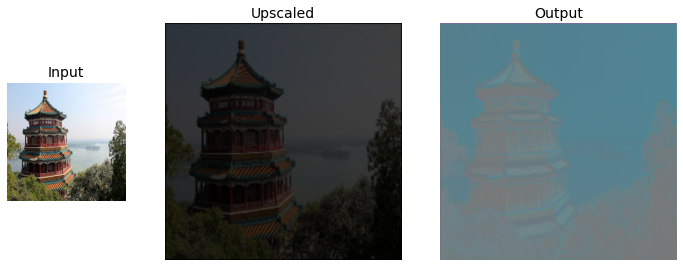

In [222]:
import matplotlib as mpl
import matplotlib.pyplot as plt
def normalize(X): # Нормализуем координаты в промежутке [0,1]
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 2, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Upscaled", fontsize=14)
ax2.imshow(upscaled[0], interpolation="bicubic")
ax2.axis("off")
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title("Output", fontsize=14)
ax3.imshow(normalize(manual_output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax3.axis("off")
plt.show()

In [175]:
np.allclose(output, manual_output.numpy(), atol=1e-7)

True

<style>
figure.img2{
  max-width: 80%;
  margin: 0 auto;
  width: content;
}

TD.leftcol {
width: 110px; /* Ширина левой колонки с рисунком */
vertical-align: top; /* Выравнивание по верхнему краю */
}
</style>

<table width="100%" cellspacing="0" cellpadding="0">
   <tr> 
    <td class="leftcol">
    <figure class="img2">
      <img 
      src="./images/book/bird.png"
      alt="">
    </figure>
    </td>
    <td valign="top" style="margin-left: 100px"> В транспонированном сверточном слое шаг определяет, насколько будут растянуты входные данные, а не размер шагов фильтра, поэтому чем больше шаг, тем больше результат (в отличие от сверточных слоев или слоев объединения). </tr>
</table>


 <head>
  <style>
   .outline {
    border: 1px solid red;
    padding: 1px;
   }
   .text-block {
   margin-left:8px;
   }
  </style>
 </head>
 <body>
  <div class="outline">
   <p><center><strong>  Операции Свертки в TensorFlow </center> </strong></p>
   <p>TensorFlow также предлагает несколько других видов сверточных слоев:</p>
   <p> <code>keras.layers.Conv1D</code> </p>
   <p> <div class="text-block"> Создает сверточный слой для одномерных входных данных, таких как временные ряды или текст (последовательности букв или слов), как мы увидим в главе 15.  </div> </p>
   <p> <code>keras.layers.Conv3D</code> </p>
   <p> <div class="text-block"> Создает сверточный слой для входных 3D-изображений, таких как 3D-сканы ПЭТ (трехмерное изображение в позитронно-эмисси­онной томографии).  </div> </p>
   <p> <code>dilation_rate</code> </p>
   <p> <div class="text-block"> Установка гиперпараметра dilation_rate любого сверточного слоя на значение 2 или более создает сверточный слой à-trous («à trous» по-французски означает «с дырками»). Это эквивалентно исполь­зованию обыкновенного сверточного слоя с фильтром, расши­ренным за счет вставки строк и столбцов нулей (т.е. отверстий). Например, фильтр 1 х 3, равный [ [ 1 , 2 , 3 ] ] , может быть расширен с коэффициентом расширения (dilation rate) 4, в результате давая расширенный фильтр [ [ 1, О, О, О, 2, О, О, О, 3 ] ] . Он позволяет сверточному слою иметь большее рецепторное поле без вычисли­тельных затрат и дополнительных параметров.   </div> </p>
   <p> <code>tf.nn.depthwise_conv2d()</code> </p>
   <p> <div class="text-block"> Может использоваться для создания глубинного сверточного слоя (но вам нужно создать переменные самостоятельно). Он применяет каждый фильтр к каждому отдельному входному каналу независимо. Таким образом, если есть фильтры f<sub>n</sub> и входные каналы f<sub>n</sub><sup>,</sup>, то будут выведены карты признаков f<sub>n</sub> × f<sub>n</sub><sup>,</sup>. </div> </p>
</div>
 </body>

Это решение в порядке, но все еще слишком неточное. Чтобы сделать лучше, авторы добавили пропуск соединений из нижних слоев: например, они повысили дискретизацию выходного изображения в 2 раза (вместо 32) и добавили выход нижнего слоя, который имел это двойное разрешение. Затем они повысили дискретизацию результата в 16 раз, что привело к общему коэффициенту повышения дискретизации 32 (см. рис. 14.28). Это восстановило часть пространственного разрешения, которое было потеряно в более ранних слоях объединения. В своей лучшей архитектуре они использовали второе аналогичное пропущенное соединение, чтобы восстановить еще более мелкие детали с еще более нижних слоев. Короче говоря, выходные данные исходной CNN проходят следующие дополнительные этапы: масштабирование ×2, добавление выходных данных нижних слоев (соответствующего масштаба), масштабирование ×2, добавление выходных данных еще более нижних слоев и, наконец, масштабирование ×8. Возможно даже масштабирование сверх размера исходного изображения: это можно использовать для увеличения разрешения изображения, что называется методом сверхразрешения.

<style>
figure.img {
  max-width: 50%;
  margin: 0 auto;
  text-align: center;
  width: content; 

}
figure.img figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
</style> 

<figure class="img">
    <img 
    src="./images/book/img28.png"
    alt="">
    <figcaption>
    Рис 14-28. Пропускные слои восстанавливают некоторое пространственное разрешение из нижних слоев.    
    </figcaption>
</figure>

Опять же, многие репозитории GitHub предоставляют реализации семантической сегментации TensorFlow (на данный момент TensorFlow 1), и вы даже найдете предварительно обученные модели сегментации экземпляров в проекте TensorFlow Models. Сегментация экземпляров аналогична семантической сегментации, но вместо того, чтобы объединять все объекты одного класса в один большой кусок, каждый объект отличается от других (например, он идентифицирует каждый отдельный велосипед). В настоящее время модели сегментации экземпляров, доступные в проекте TensorFlow Models, основаны на архитектуре Mask R-CNN, которая была предложена в статье 2017 года: она расширяет модель Faster R-CNN, дополнительно создавая пиксельную маску для каждой ограничивающей рамки. Таким образом, вы не только получаете ограничительную рамку вокруг каждого объекта с набором оценочных вероятностей классов, но также получаете пиксельную маску, которая находит пиксели в ограничительной рамке, принадлежащие объекту.

Как видите, область глубокого компьютерного зрения обширна и быстро развивается, и каждый год появляются всевозможные архитектуры, основанные на сверточных нейронных сетях. Прогресс, достигнутый всего за несколько лет, был ошеломляющим, и теперь исследователи сосредотачиваются на все более и более сложных проблемах, таких как состязательное обучение (которое пытается сделать сеть более устойчивой к изображениям, предназначенным для ее обмана), объяснимость (понимание того, почему сеть делает конкретную классификацию), создание реалистичных изображений (к которым мы вернемся в главе 17) и однократное обучение (система, которая может распознавать объект после того, как она увидела его только один раз). Некоторые даже исследуют совершенно новые архитектуры, такие как капсульные сети Джеффри Хинтона (я представил их в паре видеороликов с соответствующим кодом в блокноте). Теперь перейдем к следующей главе, в которой мы рассмотрим, как обрабатывать последовательные данные, такие как временные ряды, с помощью рекуррентных нейронных сетей и сверточных нейронных сетей.

# Упражнения

1. Каковы преимущества CNN по сравнению с полносвязной DNN для классификации изображений?
2. Рассмотрим CNN, состоящую из трех сверточных слоев, каждый из которых имеет ядра 3 × 3, шаг 2 и «same» дополнение. Самый нижний слой выводит 100 карт признаков, средний — 200, а верхний — 400. Входные изображения — это RGB-изображения размером 200 × 300 пикселей. 
Каково общее количество параметров в CNN? Если мы используем 32-битные числа с плавающей запятой, по крайней мере, сколько оперативной памяти потребуется этой сети при прогнозировании для одного экземпляра? А как насчет тренировки на мини-партии из 50 изображений?
3. Если вашему графическому процессору не хватает памяти во время обучения CNN, какие пять вещей вы могли бы попытаться решить?
4. Почему вы хотите добавить объединяющий слой по максимуму, а не сверточный слой с таким же шагом?
5. Когда вы захотите добавить слой нормализации локального ответа?
6. Назовите основные новшества в AlexNet по сравнению с LeNet-5? А как насчет основных нововведений в GoogLeNet, ResNet, SENet и Xception?
7. Что такое полностью сверточная сеть? Как вы можете преобразовать плотный слой в сверточный слой?
8. В чем основная техническая трудность семантической сегментации?
9. Создайте свою собственную CNN с нуля и попытайтесь добиться максимально возможной точности в MNIST.
10. Используйте трансферное обучение для классификации больших изображений, выполнив следующие действия:
    - Создайте обучающий набор, содержащий не менее 100 изображений для каждого класса. Например, вы можете классифицировать свои собственные изображения на основе местоположения (пляж, гора, город и т. д.) или же использовать существующий набор данных (например, из наборов данных TensorFlow).
    - Разделите его на обучающий набор, проверочный набор и тестовый набор.
    - Создайте входной конвейер, включая соответствующие операции предварительной обработки, и при необходимости добавьте увеличение данных.
    - Настройте предварительно обученную модель на этом наборе данных.
11. Пройдите руководство TensorFlow по переносу стилей. Это интересный способ создавать искусство с помощью глубокого обучения.


# Ответы 1-8

1. Вот основные преимущества CNN по сравнению с полносвязной DNN для классификации изображений:
    - Поскольку последовательные слои связаны лишь частично и активно повторно используют свои веса, CNN имеет гораздо меньше параметров, чем полностью подключенная DNN, что значительно ускоряет ее обучение, снижает риск переобучения и требует гораздо меньше данных для обучения.
    - Когда CNN обучил ядро, которое может обнаруживать конкретный признак, он так же может обнаружить этот признак в любом месте изображения. Напротив, когда DNN узнает признак в одном месте, она может обнаружить ее только в этом конкретном месте. Поскольку изображения обычно имеют очень повторяющиеся признаки, CNN могут обобщать гораздо лучше, чем DNN, для задач обработки изображений, таких как классификация, с использованием меньшего количества обучающих примеров.
    - Наконец, у DNN нет предварительных знаний о том, как организованы пиксели; он не знает, что соседние пиксели близки. Архитектура CNN включает в себя это предварительное знание. Нижние слои обычно идентифицируют объекты в небольших областях изображения, в то время как более высокие слои объединяют объекты более низкого уровня в более крупные объекты. Это хорошо работает с большинством естественных изображений, давая CNN решающее преимущество по сравнению с DNN.

2. Давайте посчитаем, сколько параметров имеет CNN:
    - Поскольку его первый сверточный слой имеет ядра 3 × 3, а входные данные имеют три канала (красный, зеленый и синий), каждая карта признаков имеет веса 3 × 3 × 3 плюс член смещения. Это 28 параметров на карту признаков. Поскольку этот первый сверточный слой имеет 100 карт признаков, он имеет в общей сложности 2800 параметров. Второй сверточный слой имеет ядра 3 × 3, и его входными данными является набор из 100 карт признаков предыдущего слоя, поэтому каждая карта признаков имеет 3 × 3 × 100 = 900 весов плюс член смещения. Поскольку у него 200 карт признаков, этот слой имеет 901 × 200 = 180200 параметров. Наконец, третий и последний сверточный слой также имеет ядра 3 × 3, и его входными данными является набор из 200 карт признаков предыдущих слоев, поэтому каждая карта признаков имеет 3 × 3 × 200 = 1800 весов плюс член смещения. Поскольку у него 400 карт признаков, этот слой имеет в общей сложности 1801 × 400 = 720400 параметров. Всего CNN имеет 2 800 + 180200 + 720400 = 903400 параметров.
    - Теперь давайте посчитаем, сколько оперативной памяти потребуется этой нейронной сети (как минимум) при прогнозировании для одного экземпляра. Сначала давайте вычислим размер карты признаков для каждого слоя. Поскольку мы используем шаг 2 и «same» заполнение, горизонтальные и вертикальные размеры карт признаков делятся на 2 на каждом слое (при необходимости округляются). Таким образом, поскольку входные каналы имеют размер 200 × 300 пикселей, карты признаков первого слоя имеют размер 100 × 150, карты признаков второго слоя — 50 × 75, а карты признаков третьего слоя — 25 × 38. Поскольку 32 бита — это 4 байта и первый сверточный слой имеет 100 карт признаков, этот первый слой занимает 4 × 100 × 150 × 100 = 6 миллионов байт (6 МБ). Второй слой занимает 4 × 50 × 75 × 200 = 3 миллиона байт (3 МБ). Наконец, третий слой занимает 4 × 25 × 38 × 400 = 1520000 байт (около 1,5 МБ). Однако после вычисления слоя память, занятая предыдущим слоем, может быть освобождена, поэтому, если все хорошо оптимизировано, потребуется только 6 + 3 = 9 миллионов байт (9 МБ) ОЗУ (когда второй слой только что был просчитан, но память, занимаемая первым слоем, еще не освобождена). Но подождите, вам также нужно добавить память, занимаемую параметрами CNN! Ранее мы подсчитали, что он имеет 903400 параметров, каждый из которых использует 4 байта, поэтому это добавляет 3613600 байтов (около 3,6 МБ). Таким образом, общая требуемая оперативная память составляет (как минимум) 12613600 байт (около 12,6 МБ).
    - Наконец, давайте вычислим минимальный объем оперативной памяти, необходимый для обучения CNN на мини-пакете из 50 изображений. Во время обучения TensorFlow использует обратное распространение, которое требует сохранения всех значений, вычисленных во время прямого прохода, до тех пор, пока не начнется обратный проход. Таким образом, мы должны вычислить общий объем ОЗУ, требуемый всеми уровнями для одного экземпляра, и умножить его на 50. На этом этапе давайте начнем считать в мегабайтах, а не в байтах. Ранее мы подсчитали, что для трех уровней требуется соответственно 6, 3 и 1,5 МБ для каждого экземпляра. Всего на экземпляр приходится 10,5 МБ, поэтому для 50 экземпляров требуется 525 МБ ОЗУ. Добавьте к этому ОЗУ, необходимое для входных изображений, которое составляет 50 × 4 × 200 × 300 × 3 = 36 миллионов байт (36 МБ), плюс ОЗУ, необходимое для параметров модели, что составляет около 3,6 МБ (рассчитано ранее), плюс немного ОЗУ для градиентов (мы пренебрежем этим, так как его можно освобождать постепенно по мере того, как обратное распространение идет вниз по слоям во время обратного прохода). В общей сложности мы получили примерно 525 + 36 + 3,6 = 564,6 МБ, и это действительно оптимистичный минимум.

3. Если вашему графическому процессору не хватает памяти во время обучения CNN, вот пять вещей, которые вы можете попробовать решить эту проблему (кроме покупки графического процессора с большим объемом оперативной памяти):
    - Уменьшите размер мини-пакета.
    - Уменьшите размерность, используя больший шаг в одном или нескольких слоях.
    - Удалите один или несколько слоев.
    - Используйте 16-битные числа с плавающей запятой вместо 32-битных.
    - Распространите CNN на несколько устройств.

4. Объединяющий слой по максимуму вообще не имеет параметров, тогда как у сверточного слоя их довольно много (см. предыдущие вопросы).

5. Эта форма нормализации заставляет нейроны, которые наиболее сильно активи­руются, подавлять нейроны в том же самом местоположении, но в соседс­твующих картах признаков. Данный прием стимулирует разные карты призна­ков специализироваться за счет их отделения и принуждения к исследова­нию более широкого диапазона признаков, что в итоге улучшает обобщение. Обычно он используется на нижних уровнях, чтобы иметь больший пул низкоуровневых признаков, на которые могут опираться верхние уровни.

6. Основные новшества в AlexNet по сравнению с LeNet-5 заключаются в том, что он намного больше и глубже, а также укладывает сверточные слои непосредственно друг на друга, вместо того, чтобы накладывать объединяющий слой поверх каждого сверточного слоя. Основное нововведение в GoogLeNet — введение модулей начала, которые позволяют иметь гораздо более глубокую сеть, чем предыдущие архитектуры CNN, с меньшим количеством параметров. Главное нововведение ResNet — введение пропускных соединений, которые позволяют выходить далеко за пределы 100 слоев. Возможно, его простота и последовательность также являются довольно инновационными. Основным нововведением SENet была идея использования блока SE (двухуровневая плотная сеть) после каждого модуля начала в начальной сети или каждой остаточной единицы в ResNet для повторной калибровки относительной важности карт признаков. Главным нововведением Xception было использование отделяемых по глубине сверточных слоев, которые рассматривают пространственные признаки и признаки по глубине отдельно.

7. Полностью сверточные сети — это нейронные сети, состоящие исключительно из сверточных и объединяющих слоев. FCN могут эффективно обрабатывать изображения любой ширины и высоты (по крайней мере, больше минимального размера). Они наиболее полезны для обнаружения объектов и семантической сегментации, потому что им нужно посмотреть на изображение только один раз (вместо того, чтобы запускать CNN несколько раз для разных частей изображения). Если у вас есть CNN с несколькими плотными слоями сверху, вы можете преобразовать эти плотные слои в сверточные слои для создания FCN: просто замените самый нижний плотный слой сверточным слоем с размером ядра, равным входному размеру слоя, с одним фильтром на нейрон в плотном слое и с использованием «valid» дополнения. Обычно шаг должен быть равен 1, но вы можете установить более высокое значение, если хотите. Функция активации должна быть такой же, как и у плотного слоя. Остальные плотные слои должны быть преобразованы таким же образом, но с использованием фильтров 1 × 1. На самом деле можно преобразовать обученную CNN таким образом, соответствующим образом изменив весовые матрицы плотных слоев.

8. Основная техническая трудность семантической сегментации заключается в том, что большая часть пространственной информации теряется в CNN по мере того, как сигнал проходит через каждый уровень, особенно при объединении слоев и слоев с шагом больше 1. Эту пространственную информацию необходимо каким-то образом восстановить, чтобы точно предсказать класс каждого пикселя.

# 9. Высокоточная CNN для MNIS

Упражнение: Создайте свою собственную CNN с нуля и попытайтесь добиться максимально возможной точности в MNIST.
В следующей модели используются 2 сверточных слоя, за которыми следует 1 слой обьединения по максимуму, затем отсев 25%, затем плотный слой, еще один слой отсева, но с отсевом 50%, и, наконец, выходной слой. достигает около 99,2%

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [3]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=3, padding="same",
                           activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Conv2D(64, kernel_size=3, padding="same",
                           activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [4]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))


Epoch 1/10
1719/1719 [==============================] - 125s 71ms/step - loss: 0.2001 - accuracy: 0.9395 - val_loss: 0.0402 - val_accuracy: 0.9902
Epoch 2/10
1719/1719 [==============================] - 126s 73ms/step - loss: 0.0809 - accuracy: 0.9764 - val_loss: 0.0412 - val_accuracy: 0.9886
Epoch 3/10
1719/1719 [==============================] - 126s 73ms/step - loss: 0.0602 - accuracy: 0.9812 - val_loss: 0.0344 - val_accuracy: 0.9900
Epoch 4/10
1719/1719 [==============================] - 133s 78ms/step - loss: 0.0499 - accuracy: 0.9850 - val_loss: 0.0319 - val_accuracy: 0.9924
Epoch 5/10
1719/1719 [==============================] - 132s 77ms/step - loss: 0.0412 - accuracy: 0.9870 - val_loss: 0.0340 - val_accuracy: 0.9918
Epoch 6/10
1719/1719 [==============================] - 138s 80ms/step - loss: 0.0358 - accuracy: 0.9888 - val_loss: 0.0398 - val_accuracy: 0.9914
Epoch 7/10
1719/1719 [==============================] - 117s 68ms/step - loss: 0.0298 - accuracy: 0.9907 - val_loss: 0

Оценка нашей модели составляет около 99,2%. 

In [5]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 3s 11ms/step - loss: 0.0305 - accuracy: 0.9924


[0.030501501634716988, 0.9923999905586243]

# 10. Используйте трансферное обучение для классификации больших изображений

Упражнение: Используйте трансферное обучение для классификации больших изображений, выполнив следующие действия:
- Создайте обучающий набор, содержащий не менее 100 изображений для каждого класса. Например, вы можете классифицировать свои собственные изображения на основе местоположения (пляж, гора, город и т. д.) или же использовать существующий набор данных (например, из наборов данных TensorFlow).
- Разделите его на обучающий набор, проверочный набор и тестовый набор.
- Создайте входной конвейер, включая соответствующие операции предварительной обработки, и при необходимости добавьте увеличение данных.
- Настройте предварительно обученную модель на этом наборе данных.

# 11. Передача стиля TensorFlow.

Упражнение: просмотрите руководство по передаче стилей TensorFlow. Это интересный способ создавать искусство с помощью глубокого обучения.

Просто откройте Colab и следуйте его инструкциям.